<a href="https://colab.research.google.com/github/Sunnnyyy16/Dacon_study/blob/main/FIFA_payment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DACON FIFA 선수 이적료 예측 경진대회
대회 사이트: https://dacon.io/competitions/open/235538/data

# 목차
0. 데이터 로드
1. 데이터 EDA, visualization
2. 데이터 전처리
3. 모델 생성 및 학습
4. 결론

* 참고



# 0.데이터로드

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
!cp /gdrive/MyDrive/Dacon_study/FIFA/FIFA_test.csv ./
!cp /gdrive/MyDrive/Dacon_study/FIFA/FIFA_train.csv ./
!cp /gdrive/MyDrive/Dacon_study/FIFA/submission.csv ./

In [ ]:
train = pd.read_csv('FIFA_train.csv')
test = pd.read_csv('FIFA_test.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


* id: 선수 고유 아이디
* name: 이름
* age: 나이
* continent : 선수 국적이 포함된 대륙
* contract_until: 선수 계약 기간이 언제까지인지
* position: 선수가 선호하는 포지션 ex) 공격수, 수비수 등
* prefet_foot : 선수가 선호하는 발 ex)오른발
* reputation: 선수가 윰여한 정도 ex) 높은 수치일 수록 유명한 선수
* stat_overall : 선수의 현재 능력치
* stat_potential: 선수가 경험 및 노력을 통해 발전할 수 있는 정도
* stat_skill_moves: 선수의 개인기 능력칙
* value: FIFA가 선정한 선수 이적 시장 가격 (단위:유로)

In [ ]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [ ]:
print(train.shape)
print(test.shape)

(8932, 12)
(3828, 11)


# 1.데이터 EDA, visualization

In [ ]:
train.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


## data cleansing

In [ ]:
train.isnull().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
value               0
dtype: int64

In [ ]:
test.isnull().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
dtype: int64

null값 처리 불필요

In [ ]:
# 10 players who have high value
train.sort_values(by='value',ascending=False).head(10)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
17,30,Isco,26,europe,2022,ST,right,3.0,88,91,4.0,73500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
14,26,M. Salah,26,africa,2023,MF,left,3.0,88,89,4.0,69500000.0
18,32,Coutinho,26,south america,2023,ST,right,3.0,88,89,5.0,69500000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0
26,45,P. Pogba,25,europe,2021,MF,right,4.0,87,91,5.0,64000000.0
7,14,N. Kanté,27,europe,2023,MF,right,3.0,89,90,2.0,63000000.0
27,47,R. Lukaku,25,europe,2022,ST,left,3.0,87,89,3.0,62500000.0


연봉 Top 10 선수들

In [ ]:
# 10 players who have high reputation 
train.sort_values(by='reputation',ascending=False).head(10)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
65,109,Z. Ibrahimović,36,europe,2022,ST,right,5.0,85,85,5.0,14000000.0
12,22,M. Neuer,32,europe,2021,GK,right,5.0,89,89,1.0,38000000.0
61,105,K. Benzema,30,europe,2021,ST,right,4.0,85,85,4.0,37000000.0
32,54,Piqué,31,europe,2022,DF,right,4.0,87,87,2.0,34000000.0
38,66,T. Müller,28,europe,2021,MF,right,4.0,86,86,3.0,45000000.0
40,68,M. Reus,29,europe,2023,MF,right,4.0,86,86,4.0,43500000.0
43,76,Iniesta,34,europe,2021,ST,right,4.0,86,86,4.0,21500000.0
231,378,Hulk,31,south america,2020,MF,left,4.0,81,81,4.0,15500000.0


기여 top 10 선수들

메시, 수아레즈는 연봉도 제일 높고 기여도도 높다

In [ ]:
# continent별 reputation, stat_overall, stat_potential, stat_skill_moves 평균 
train.groupby('continent')['reputation','stat_overall','stat_potential','stat_skill_moves','value'].mean().reset_index()

,continent,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,africa,1.122053,68.041609,72.360610,2.606103,2.972247e+06
1,asia,1.054638,63.381194,68.208386,2.259212,1.035146e+06
2,europe,1.146937,67.083051,72.387636,2.371665,2.928125e+06
3,oceania,1.022857,63.011429,68.640000,2.234286,8.225429e+05
4,south america,1.130773,68.643487,72.635184,2.481578,3.183204e+06


대륙별 기여도 평균: 아프라카> 아시아> 유럽 > 오세아니아 > 남아메리카

## 시각화

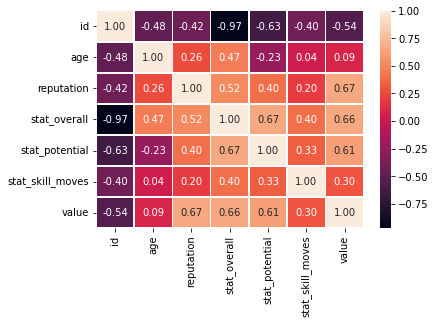

In [ ]:
# 상관계수
plt.figure()
sns.heatmap(data=train.corr(),annot=True,fmt='.2f',linewidths=.5)

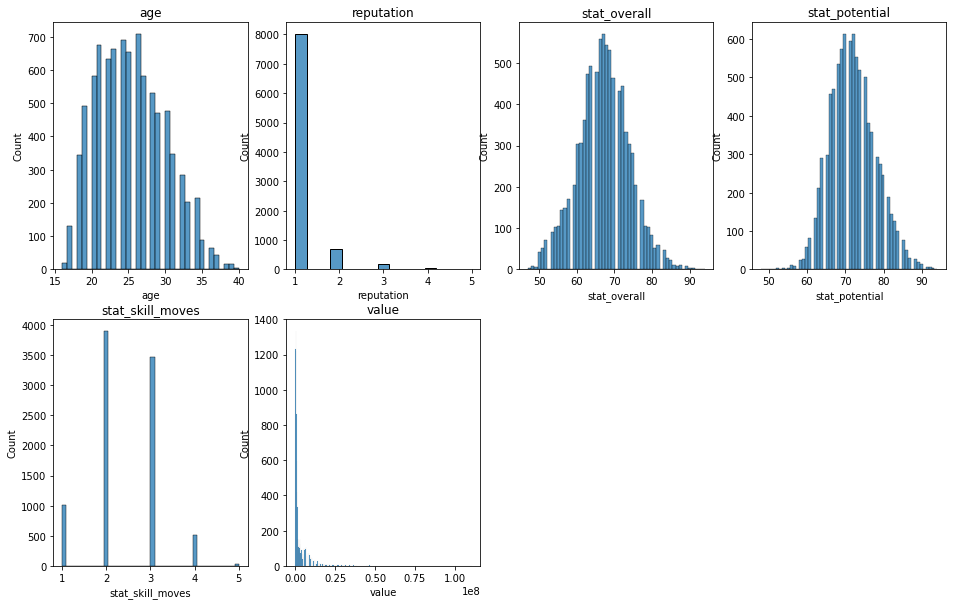

In [ ]:
# histplot으로 수치형 데이터 분포 확인
plt.figure(figsize=(16,10))

cols = train.columns[7:].insert(0,'age')
for i in range(len(cols)):
  plt.subplot(2,4,i+1)
  plt.title(cols[i])
  sns.histplot(train[cols[i]])
plt.show()

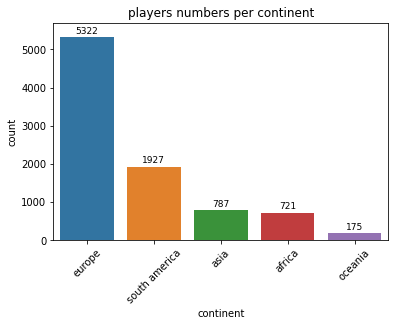

In [ ]:
ax= sns.countplot(x='continent',data=train, order = train['continent'].value_counts().index)

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width() / 2., height + 100, height, ha = 'center', size = 9)
ax.set_ylim(0,5700)

plt.xticks(rotation=45)

plt.title('players numbers per continent')
plt.show()

유럽출신 선수들이 제일 많다

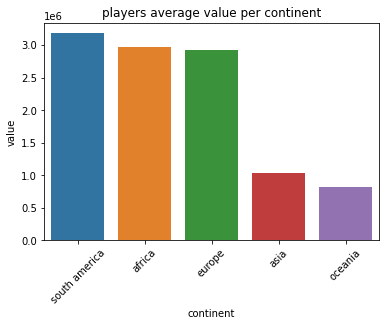

In [ ]:
plt.figure()
sns.barplot(x='continent',y='value',data=train.groupby('continent')['value'].mean().reset_index().sort_values(by='value',ascending=False))

plt.xticks(rotation=45)

plt.title('players average value per continent')
plt.show()

value 평균 : south america > africa > europe > asia > oceania

In [ ]:
train.groupby('continent')['value'].mean().reset_index().sort_values(by='value',ascending=False)

,continent,value
4,south america,3.183204e+06
0,africa,2.972247e+06
2,europe,2.928125e+06
1,asia,1.035146e+06
3,oceania,8.225429e+05


대륙별 value 평균 : south america > africa > europe > asia > oceania

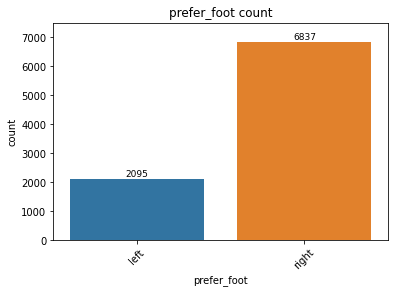

In [ ]:
ax= sns.countplot(x='prefer_foot',data=train)

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width() / 2., height + 100, height, ha = 'center', size = 9)
ax.set_ylim(0,7500)

plt.xticks(rotation=45)

plt.title('prefer_foot count')
plt.show()

오른발 선호하는 선수가 매우 많음

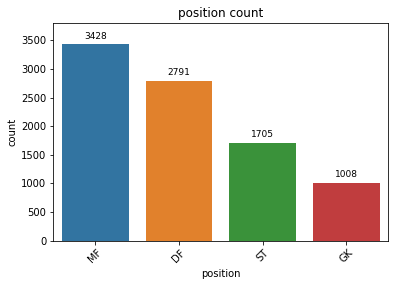

In [ ]:
ax= sns.countplot(x='position',data=train, order= train['position'].value_counts().index)

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width() / 2., height + 100, height, ha = 'center', size = 9)
ax.set_ylim(0,3800)

plt.xticks(rotation=45)

plt.title('position count')
plt.show()

MF (미드필더) > DF(Defensive Midfielder) > ST(striker) > GK (골키퍼)

# 2.데이터전처리

In [ ]:
train['contract_until'].value_counts()

2019            2366
2021            2308
2020            2041
2022             761
2023             506
Jun 30, 2019     501
2018             327
Dec 31, 2018      64
May 31, 2019      19
2024              12
Jan 31, 2019      10
Jun 30, 2020       9
2025               3
Jan 1, 2019        2
2026               1
May 31, 2020       1
Jan 12, 2019       1
Name: contract_until, dtype: int64

In [ ]:
# 계약 연도 추출
train['contract_until'] = train['contract_until'].str[-4:].astype(int)
test['contract_until'] = test['contract_until'].str[-4:].astype(int)

In [ ]:
train['contract_until'].value_counts()

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       3
2026       1
Name: contract_until, dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   int64  
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 837.5+ KB


## 라벨인코딩

In [ ]:
train.groupby('continent').value.mean().sort_values()

continent
oceania          8.225429e+05
asia             1.035146e+06
europe           2.928125e+06
africa           2.972247e+06
south america    3.183204e+06
Name: value, dtype: float64

In [ ]:
train["continent_rank"] = train.continent.map({'oceania':1, 'asia': 2,'europe':3, 'africa':4, 'south america':5})
test["continent_rank"] = test.continent.map({'oceania':1, 'asia': 2,'europe':3, 'africa':4, 'south america':5})

In [ ]:
train.groupby('position').value.mean().sort_values()

position
GK    1.992073e+06
DF    2.304348e+06
MF    3.121762e+06
ST    3.330361e+06
Name: value, dtype: float64

In [ ]:
train['position_rank'] = train.position.map({'GK':1,'DF':2,'MF':3,'ST':4})
test['position_rank'] = test.position.map({'GK':1,'DF':2,'MF':3,'ST':4})

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoder.fit(train['prefer_foot'])
train['prefer_foot'] = encoder.transform(train['prefer_foot'])
test['prefer_foot'] = encoder.transform(test['prefer_foot'])

## Standard Scaling

In [ ]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,continent_rank,position_rank
0,0,L. Messi,31,south america,2021,ST,0,5.0,94,94,4.0,110500000.0,5,4
1,3,De Gea,27,europe,2020,GK,1,4.0,91,93,1.0,72000000.0,3,1
2,7,L. Suárez,31,south america,2021,ST,1,5.0,91,91,3.0,80000000.0,5,4
3,8,Sergio Ramos,32,europe,2020,DF,1,4.0,91,91,3.0,51000000.0,3,2
4,9,J. Oblak,25,europe,2021,GK,1,3.0,90,93,1.0,68000000.0,3,1


In [ ]:
#Standard scaler
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
scaler= StandardScaler()

# 변환 필요 없는 feature는 제외
transform_df= train[['age','reputation','stat_overall','stat_potential','stat_skill_moves']]

std_transform_df = scaler.fit_transform(transform_df)
train[transform_df.columns] = std_transform_df
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,continent_rank,position_rank
0,0,L. Messi,1.249309,south america,2021,ST,0,9.130280,3.925708,3.674598,2.059652,110500000.0,5,4
1,3,De Gea,0.386357,europe,2020,GK,1,6.770499,3.488041,3.507592,-1.806307,72000000.0,3,1
2,7,L. Suárez,1.249309,south america,2021,ST,1,9.130280,3.488041,3.173580,0.770999,80000000.0,5,4
3,8,Sergio Ramos,1.465046,europe,2020,DF,1,6.770499,3.488041,3.173580,0.770999,51000000.0,3,2
4,9,J. Oblak,-0.045118,europe,2021,GK,1,4.410719,3.342152,3.507592,-1.806307,68000000.0,3,1


## feature engineering

# 3.모델생성 및 학습

## train, val 데이터 split

In [69]:
X= train.drop(['id','name','continent','position','value'],axis=1)
y=train['value']

In [70]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8932 non-null   float64
 1   contract_until    8932 non-null   int64  
 2   prefer_foot       8932 non-null   int64  
 3   reputation        8932 non-null   float64
 4   stat_overall      8932 non-null   float64
 5   stat_potential    8932 non-null   float64
 6   stat_skill_moves  8932 non-null   float64
 7   continent_rank    8932 non-null   int64  
 8   position_rank     8932 non-null   int64  
dtypes: float64(5), int64(4)
memory usage: 628.2 KB


In [71]:
X.head()

,age,contract_until,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,continent_rank,position_rank
0,1.249309,2021,0,9.130280,3.925708,3.674598,2.059652,5,4
1,0.386357,2020,1,6.770499,3.488041,3.507592,-1.806307,3,1
2,1.249309,2021,1,9.130280,3.488041,3.173580,0.770999,5,4
3,1.465046,2020,1,6.770499,3.488041,3.173580,0.770999,3,2
4,-0.045118,2021,1,4.410719,3.342152,3.507592,-1.806307,3,1


In [72]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X,y, test_size=.20, random_state=42)

## K fold

## RandomForest

### 학습

In [73]:
# 모델링 라이브러리
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(train_x, train_y)
pred= rf_reg.predict(val_x)

mse= mean_squared_error(val_y, pred)
rmse= mse**(1/2)

print("RMSE: ", rmse)

RMSE:  1242688.613950242


### 하이퍼파라미터 튜닝-optuna

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached optuna-3.0.5-py3-none-any.whl (348 kB)
  Using cached cmaes-0.9.0-py3-none-any.whl (23 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached cliff-4.1.0-py3-none-any.whl (81 kB)
  Using cached alembic-1.9.0-py3-none-any.whl (210 kB)
  Using cached importlib_metadata-4.13.0-py3-none-any.whl (23 kB)
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
  Using cached autopage-0.5.1-py3-none-any.whl (29 kB)
  Using cached stevedore-4.1.1-py3-none-any.whl (50 kB)
  Using cached cmd2-2.4.2-py3-none-any.whl (147 kB)
  Using cached pyperclip-1.8.2-py3-none-any.whl
  Using cached pbr-5.11.0-py2.py3-none-any.whl (112 kB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      Successfully uninstalled importlib-metadata-5.1.0


In [ ]:
# optuna libraries
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [74]:
# random sampler
sampler = TPESampler(seed=10)

def objective(trial):
  
  rf_param = {
      'max_depth':trial.suggest_int('max_depth',1,10),
      'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',2,1000),
      'n_estimators':trial.suggest_int('n_estimators',100,500),
  }

  model_rf = RandomForestRegressor(**rf_param)

  model_rf = model_rf.fit(train_x, train_y)

  # 평가지표
  MSE = mean_squared_error(val_y, model_rf.predict(val_x))
  
  return MSE

optuna_rf = optuna.create_study(direction='minimize', sampler = sampler)
optuna_rf.optimize(objective, n_trials=100)

[I 2022-12-20 11:35:11,937] A new study created in memory with name: no-name-558dc732-8751-4efb-974a-4cfff2c6cd34
[I 2022-12-20 11:35:13,883] Trial 0 finished with value: 2605416913383.4614 and parameters: {'max_depth': 8, 'max_leaf_nodes': 22, 'n_estimators': 354}. Best is trial 0 with value: 2605416913383.4614.
[I 2022-12-20 11:35:15,562] Trial 1 finished with value: 1653346552225.4846 and parameters: {'max_depth': 8, 'max_leaf_nodes': 500, 'n_estimators': 190}. Best is trial 1 with value: 1653346552225.4846.
[I 2022-12-20 11:35:16,103] Trial 2 finished with value: 7931871610070.641 and parameters: {'max_depth': 2, 'max_leaf_nodes': 761, 'n_estimators': 167}. Best is trial 1 with value: 1653346552225.4846.
[I 2022-12-20 11:35:17,220] Trial 3 finished with value: 17255953524642.135 and parameters: {'max_depth': 1, 'max_leaf_nodes': 686, 'n_estimators': 482}. Best is trial 1 with value: 1653346552225.4846.
[I 2022-12-20 11:35:18,187] Trial 4 finished with value: 17287555081800.717 and 

In [75]:
rf_trial = optuna_rf.best_trial
rf_trial_params = rf_trial.params

print('Best Trial: score {}, \nparams {}' .format(rf_trial.value, rf_trial_params))

Best Trial: score 1529372321794.0122, 
params {'max_depth': 9, 'max_leaf_nodes': 570, 'n_estimators': 110}


In [76]:
# modeling fit
rf_regop = RandomForestRegressor(**rf_trial_params)
rf_study = rf_regop.fit(train_x,train_y)

rf_pred_op = rf_regop.predict(val_x)
mse = mean_squared_error(val_y, rf_pred_op)
rmse = mse**(1/2)

print("RMSE : ", rmse)

RMSE :  1337248.9432518266


## XGBoost

### 학습

In [77]:
# 모델링 라이브러리
# 모델링 관련 라이브러리
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor

In [78]:
xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42, eval_set=[val_x,val_y])

print(len(train_x), len(val_x))
xgb_reg.fit(train_x, train_y)
pred = xgb_reg.predict(val_x)
mse = mean_squared_error(val_y,pred)
rmse = mse**(1/2)

print("RMSE : ", rmse)

7145 1787
RMSE :  977307.6347815989


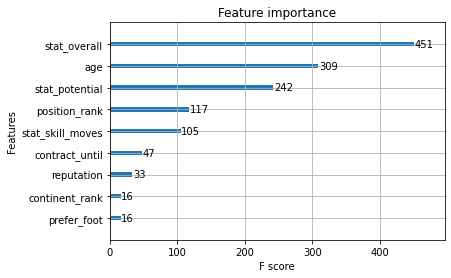

In [79]:
xgb.plot_importance(xgb_reg)

### 하이퍼파라미터 튜닝 - optuna

In [80]:
# optuna libraries
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [81]:
# random sampler
sampler = TPESampler(seed=10)

#define function
def objective(trial):
  
  param = {
      'objective':'reg:squarederror',
      'verbose':-1,
      'metric':'mse',
      'num_leaves':trial.suggest_int('num_leaves',2,1024, step=1, log=True),
      'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.7,1.0),
      'reg_alpha': trial.suggest_uniform('reg_alpha',0.0,1.0),
      'reg_lambda':trial.suggest_uniform('reg_lambda',0.0,10.0),
      'max_depth': trial.suggest_int('max_depth',3,15),
      'learning_rate': trial.suggest_loguniform('learning_rate',0.0001,0.99),
      'n_estimators': trial.suggest_int('n_estimators',100,3000),
      'min_child_weight': trial.suggest_int('min_child_weight',2,15),
      'subsample': trial.suggest_loguniform('subsample',0.4,1),
  }
  # generate model
  model_xgb = XGBRegressor(**param)
  model_xgb = model_xgb.fit(train_x, train_y, eval_set=[(val_x, val_y)], 
                            verbose=0, early_stopping_rounds=25)
  
  # 평가 지표
  MSE = mean_squared_error(val_y, model_xgb.predict(val_x))
  return MSE

optuna_xgb = optuna.create_study(direction="minimize", sampler=sampler)

optuna_xgb.optimize(objective, n_trials=100)

[I 2022-12-20 11:42:31,369] A new study created in memory with name: no-name-998429b9-017d-40cc-9b77-844e51f23578
[I 2022-12-20 11:42:37,393] Trial 0 finished with value: 27435227420017.79 and parameters: {'num_leaves': 230, 'colsample_bytree': 0.7062255848078204, 'reg_alpha': 0.6336482349262754, 'reg_lambda': 7.488038825386118, 'max_depth': 9, 'learning_rate': 0.0007910526477470923, 'n_estimators': 674, 'min_child_weight': 12, 'subsample': 0.46704202331689854}. Best is trial 0 with value: 27435227420017.79.
[I 2022-12-20 11:42:39,747] Trial 1 finished with value: 1935362215545.6692 and parameters: {'num_leaves': 3, 'colsample_bytree': 0.9056079455103392, 'reg_alpha': 0.9533933461949365, 'reg_lambda': 0.039482663279144514, 'max_depth': 9, 'learning_rate': 0.17657813040997375, 'n_estimators': 1876, 'min_child_weight': 12, 'subsample': 0.5226478358414336}. Best is trial 1 with value: 1935362215545.6692.
[I 2022-12-20 11:42:46,616] Trial 2 finished with value: 1272454809787.2163 and param

In [82]:
xgb_trial = optuna_xgb.best_trial
xgb_trial_params = xgb_trial.params
print('Best Trial: score {}, \nparams {}' .format(xgb_trial.value, xgb_trial_params))

Best Trial: score 862637620241.0383, 
params {'num_leaves': 28, 'colsample_bytree': 0.953213724070638, 'reg_alpha': 0.9652378119472581, 'reg_lambda': 4.852112317877047, 'max_depth': 12, 'learning_rate': 0.044753332952168205, 'n_estimators': 2009, 'min_child_weight': 2, 'subsample': 0.8636063750313355}


In [83]:
# modeling fit
xgb_regop = XGBRegressor(**xgb_trial_params)
xgb_study = xgb_regop.fit(train_x, train_y)

xgb_pred_op =xgb_regop.predict(val_x)
mse = mean_squared_error(val_y, xgb_pred_op)
rmse = mse**(1/2)

print("RMSE : ", rmse)

[12:03:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  928825.3592130346


## catboost

### 학습

In [84]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
# 모델링 라이브러리
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [86]:
cat_reg = CatBoostRegressor(n_estimators=200, random_state=42)

cat_reg.fit(train_x,train_y)
pred = cat_reg.predict(val_x)
mse = mean_squared_error(val_y,pred)
rmse = mse**(1/2)

print("RMSE: ",rmse)

Learning rate set to 0.206716
0:	learn: 4665953.9225366	total: 7.57ms	remaining: 1.5s
1:	learn: 3925475.3092584	total: 10.8ms	remaining: 1.07s
2:	learn: 3291768.1739785	total: 13ms	remaining: 852ms
3:	learn: 2766193.1944512	total: 14.4ms	remaining: 705ms
4:	learn: 2332208.1244672	total: 16.2ms	remaining: 632ms
5:	learn: 2008977.7083186	total: 17.8ms	remaining: 575ms
6:	learn: 1733161.4403914	total: 19.1ms	remaining: 528ms
7:	learn: 1502970.1690609	total: 20.5ms	remaining: 492ms
8:	learn: 1335059.3049741	total: 22ms	remaining: 466ms
9:	learn: 1187534.3951638	total: 23.3ms	remaining: 443ms
10:	learn: 1060919.7979437	total: 25.2ms	remaining: 432ms
11:	learn: 960620.2214716	total: 26.9ms	remaining: 422ms
12:	learn: 900239.6873120	total: 28.5ms	remaining: 410ms
13:	learn: 836749.8274738	total: 33.3ms	remaining: 442ms
14:	learn: 772195.1956420	total: 35.3ms	remaining: 436ms
15:	learn: 719294.5092384	total: 37.1ms	remaining: 426ms
16:	learn: 677056.4837113	total: 39.1ms	remaining: 421ms
17:	l

### 하이퍼파라미터 튜닝 - optuna

In [87]:
# random sampler
sampler = TPESampler(seed=10)

def objective(trial):

  cat_param = {
      'max_depth':trial.suggest_int('max_depth', 2, 12),
      'min_child_samples':trial.suggest_int('min_child_samples', 5, 100),
      'n_estimators':trial.suggest_int('n_estimators', 100, 500),
      'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.3)
  }
  
  model_cat = CatBoostRegressor(**cat_param)
    
  model_cat = model_cat.fit(train_x, train_y)    
  
  # 평가지표
  MSE = mean_squared_error(val_y, model_cat.predict(val_x))

  return MSE
  
optuna_cat = optuna.create_study(direction='minimize',sampler = sampler)

optuna_cat.optimize(objective, n_trials=100)

[I 2022-12-20 12:03:44,616] A new study created in memory with name: no-name-5c65daa0-de0d-4dde-b92b-1915f4f182dc


0:	learn: 5115674.6293470	total: 10.1ms	remaining: 3.57s
1:	learn: 4668907.4457004	total: 16.8ms	remaining: 2.95s
2:	learn: 4216780.5358669	total: 19.4ms	remaining: 2.26s
3:	learn: 3813624.5711517	total: 24.6ms	remaining: 2.16s
4:	learn: 3453717.7850075	total: 29.3ms	remaining: 2.04s
5:	learn: 3171744.7177541	total: 33.1ms	remaining: 1.92s
6:	learn: 2864892.5023413	total: 37.4ms	remaining: 1.85s
7:	learn: 2597382.7455801	total: 41.5ms	remaining: 1.8s
8:	learn: 2383392.6112596	total: 45.7ms	remaining: 1.75s
9:	learn: 2162940.5505222	total: 50ms	remaining: 1.72s
10:	learn: 1972837.5145391	total: 53.9ms	remaining: 1.68s
11:	learn: 1813414.6904114	total: 57.2ms	remaining: 1.63s
12:	learn: 1661410.2204734	total: 61.4ms	remaining: 1.61s
13:	learn: 1522074.1965107	total: 67.4ms	remaining: 1.64s
14:	learn: 1399319.2411836	total: 76.3ms	remaining: 1.72s
15:	learn: 1296625.2297393	total: 91.1ms	remaining: 1.92s
16:	learn: 1201798.3582110	total: 104ms	remaining: 2.06s
17:	learn: 1109346.3479480	t

[I 2022-12-20 12:03:46,836] Trial 0 finished with value: 1951439784498.311 and parameters: {'max_depth': 10, 'min_child_samples': 6, 'n_estimators': 354, 'learning_rate': 0.12766567050674044}. Best is trial 0 with value: 1951439784498.311.


0:	learn: 5036941.9110022	total: 6.39ms	remaining: 1.14s
1:	learn: 4513324.7766331	total: 9.84ms	remaining: 871ms
2:	learn: 4075053.7351641	total: 15ms	remaining: 878ms
3:	learn: 3687364.3928351	total: 20.1ms	remaining: 881ms
4:	learn: 3312099.0834549	total: 25.4ms	remaining: 883ms
5:	learn: 2981577.9205166	total: 30.5ms	remaining: 880ms
6:	learn: 2672020.7152676	total: 32.3ms	remaining: 794ms
7:	learn: 2426570.5209486	total: 34.6ms	remaining: 740ms
8:	learn: 2203075.6293611	total: 36.4ms	remaining: 688ms
9:	learn: 2026889.4038664	total: 38ms	remaining: 642ms
10:	learn: 1839864.8785339	total: 39.6ms	remaining: 605ms
11:	learn: 1675749.6351719	total: 41.3ms	remaining: 574ms
12:	learn: 1540084.0777958	total: 43.4ms	remaining: 555ms
13:	learn: 1422940.0165896	total: 47.4ms	remaining: 559ms
14:	learn: 1313654.8861039	total: 51.8ms	remaining: 567ms
15:	learn: 1218455.7588869	total: 56ms	remaining: 570ms
16:	learn: 1131782.4943772	total: 60.9ms	remaining: 581ms
17:	learn: 1058350.8845140	tot

[I 2022-12-20 12:03:47,402] Trial 1 finished with value: 1528009579098.3684 and parameters: {'max_depth': 7, 'min_child_samples': 26, 'n_estimators': 179, 'learning_rate': 0.13286056037300167}. Best is trial 1 with value: 1528009579098.3684.


134:	learn: 258745.9599192	total: 352ms	remaining: 115ms
135:	learn: 257584.6002505	total: 354ms	remaining: 112ms
136:	learn: 256551.3799573	total: 356ms	remaining: 109ms
137:	learn: 255633.7881452	total: 360ms	remaining: 107ms
138:	learn: 254732.8592976	total: 364ms	remaining: 105ms
139:	learn: 254170.0862692	total: 365ms	remaining: 102ms
140:	learn: 253331.0905713	total: 368ms	remaining: 99.1ms
141:	learn: 252325.5179161	total: 369ms	remaining: 96.2ms
142:	learn: 250632.5613878	total: 371ms	remaining: 93.5ms
143:	learn: 249724.3710771	total: 373ms	remaining: 90.7ms
144:	learn: 248858.0463861	total: 375ms	remaining: 87.8ms
145:	learn: 248395.9819493	total: 376ms	remaining: 85ms
146:	learn: 247561.1116282	total: 378ms	remaining: 82.2ms
147:	learn: 246858.0348972	total: 379ms	remaining: 79.4ms
148:	learn: 245937.8523590	total: 381ms	remaining: 76.7ms
149:	learn: 245574.0789899	total: 383ms	remaining: 74ms
150:	learn: 244705.6909256	total: 384ms	remaining: 71.2ms
151:	learn: 243955.92629

[I 2022-12-20 12:03:48,018] Trial 2 finished with value: 947270938405.9606 and parameters: {'max_depth': 3, 'min_child_samples': 13, 'n_estimators': 374, 'learning_rate': 0.2560221708894264}. Best is trial 2 with value: 947270938405.9606.


304:	learn: 266817.4906942	total: 423ms	remaining: 95.6ms
305:	learn: 266473.3306585	total: 424ms	remaining: 94.2ms
306:	learn: 266332.1663964	total: 427ms	remaining: 93.1ms
307:	learn: 265988.8888002	total: 431ms	remaining: 92.4ms
308:	learn: 265882.4899960	total: 432ms	remaining: 90.9ms
309:	learn: 265222.9132204	total: 433ms	remaining: 89.4ms
310:	learn: 264562.3721141	total: 434ms	remaining: 87.9ms
311:	learn: 264541.1482491	total: 435ms	remaining: 86.5ms
312:	learn: 264522.5670246	total: 436ms	remaining: 85ms
313:	learn: 264506.2983169	total: 438ms	remaining: 83.6ms
314:	learn: 263827.1248079	total: 439ms	remaining: 82.2ms
315:	learn: 263310.6633502	total: 440ms	remaining: 80.8ms
316:	learn: 263090.0124902	total: 441ms	remaining: 79.3ms
317:	learn: 262828.6552217	total: 442ms	remaining: 77.9ms
318:	learn: 262428.3028121	total: 443ms	remaining: 76.5ms
319:	learn: 262058.2072208	total: 445ms	remaining: 75ms
320:	learn: 261691.0186268	total: 446ms	remaining: 73.7ms
321:	learn: 261675

[I 2022-12-20 12:03:48,660] Trial 3 finished with value: 874420891562.65 and parameters: {'max_depth': 2, 'min_child_samples': 54, 'n_estimators': 425, 'learning_rate': 0.0803110441567395}. Best is trial 3 with value: 874420891562.65.


340:	learn: 489008.5370991	total: 437ms	remaining: 108ms
341:	learn: 488491.6059931	total: 442ms	remaining: 107ms
342:	learn: 488149.6385014	total: 443ms	remaining: 106ms
343:	learn: 485867.6475862	total: 444ms	remaining: 105ms
344:	learn: 485005.6130279	total: 445ms	remaining: 103ms
345:	learn: 484134.2770186	total: 446ms	remaining: 102ms
346:	learn: 483669.7643429	total: 448ms	remaining: 101ms
347:	learn: 482856.3929049	total: 449ms	remaining: 99.3ms
348:	learn: 482605.0766864	total: 450ms	remaining: 98ms
349:	learn: 481995.4167275	total: 451ms	remaining: 96.7ms
350:	learn: 481848.3410785	total: 452ms	remaining: 95.3ms
351:	learn: 481097.0736248	total: 453ms	remaining: 94ms
352:	learn: 479167.2242149	total: 454ms	remaining: 92.7ms
353:	learn: 477892.2120773	total: 455ms	remaining: 91.3ms
354:	learn: 476324.7360476	total: 456ms	remaining: 90ms
355:	learn: 476143.9006025	total: 457ms	remaining: 88.7ms
356:	learn: 475366.7613987	total: 459ms	remaining: 87.3ms
357:	learn: 474841.1616674	

[I 2022-12-20 12:03:51,720] Trial 4 finished with value: 1841949753805.7244 and parameters: {'max_depth': 9, 'min_child_samples': 33, 'n_estimators': 468, 'learning_rate': 0.11363577488646587}. Best is trial 3 with value: 874420891562.65.


0:	learn: 5178420.5354575	total: 5.1ms	remaining: 1.26s
1:	learn: 4793349.2906618	total: 7.76ms	remaining: 959ms
2:	learn: 4416797.9779415	total: 10.5ms	remaining: 858ms
3:	learn: 4084379.7937564	total: 12.4ms	remaining: 760ms
4:	learn: 3766979.9924622	total: 14.2ms	remaining: 693ms
5:	learn: 3477921.7971340	total: 15.8ms	remaining: 641ms
6:	learn: 3211608.6432420	total: 17.5ms	remaining: 605ms
7:	learn: 2987300.0360507	total: 19.4ms	remaining: 586ms
8:	learn: 2755125.3439951	total: 22.1ms	remaining: 589ms
9:	learn: 2558868.4612335	total: 23.7ms	remaining: 567ms
10:	learn: 2385528.5517201	total: 25.4ms	remaining: 550ms
11:	learn: 2212342.1660342	total: 27.3ms	remaining: 538ms
12:	learn: 2069063.7425974	total: 29ms	remaining: 526ms
13:	learn: 1925183.0406177	total: 31.4ms	remaining: 527ms
14:	learn: 1810790.6010770	total: 33.5ms	remaining: 522ms
15:	learn: 1692188.0581123	total: 35.3ms	remaining: 514ms
16:	learn: 1592232.8787104	total: 37ms	remaining: 505ms
17:	learn: 1495657.5131582	to

[I 2022-12-20 12:03:52,939] Trial 5 finished with value: 1491393581054.4648 and parameters: {'max_depth': 7, 'min_child_samples': 18, 'n_estimators': 249, 'learning_rate': 0.0990323514868435}. Best is trial 3 with value: 874420891562.65.


218:	learn: 225129.3196461	total: 891ms	remaining: 122ms
219:	learn: 224907.2723340	total: 895ms	remaining: 118ms
220:	learn: 224347.5523343	total: 900ms	remaining: 114ms
221:	learn: 223816.0258033	total: 920ms	remaining: 112ms
222:	learn: 223504.6594873	total: 923ms	remaining: 108ms
223:	learn: 223128.9270024	total: 931ms	remaining: 104ms
224:	learn: 222730.0929816	total: 933ms	remaining: 99.5ms
225:	learn: 222175.3541912	total: 934ms	remaining: 95.1ms
226:	learn: 221769.5311789	total: 936ms	remaining: 90.7ms
227:	learn: 221033.9627992	total: 938ms	remaining: 86.4ms
228:	learn: 220630.7498783	total: 941ms	remaining: 82.1ms
229:	learn: 220195.4682002	total: 942ms	remaining: 77.8ms
230:	learn: 219755.4554108	total: 944ms	remaining: 73.6ms
231:	learn: 219254.8161842	total: 946ms	remaining: 69.3ms
232:	learn: 218754.0839781	total: 948ms	remaining: 65.1ms
233:	learn: 218474.6048783	total: 949ms	remaining: 60.9ms
234:	learn: 217993.5094293	total: 952ms	remaining: 56.7ms
235:	learn: 217615.8

[I 2022-12-20 12:03:54,856] Trial 6 finished with value: 1383318240858.193 and parameters: {'max_depth': 6, 'min_child_samples': 46, 'n_estimators': 347, 'learning_rate': 0.057275304226203264}. Best is trial 3 with value: 874420891562.65.


311:	learn: 270941.6863847	total: 1.42s	remaining: 159ms
312:	learn: 270471.2906568	total: 1.42s	remaining: 154ms
313:	learn: 270195.5867157	total: 1.43s	remaining: 150ms
314:	learn: 269846.4421738	total: 1.44s	remaining: 147ms
315:	learn: 269349.6542062	total: 1.45s	remaining: 142ms
316:	learn: 269033.4863090	total: 1.45s	remaining: 137ms
317:	learn: 268758.6352202	total: 1.45s	remaining: 132ms
318:	learn: 268283.2748325	total: 1.45s	remaining: 128ms
319:	learn: 267840.5158492	total: 1.45s	remaining: 123ms
320:	learn: 267351.8168980	total: 1.46s	remaining: 118ms
321:	learn: 267015.9227185	total: 1.46s	remaining: 113ms
322:	learn: 266696.6321129	total: 1.46s	remaining: 108ms
323:	learn: 266395.7089279	total: 1.46s	remaining: 104ms
324:	learn: 266027.6618913	total: 1.46s	remaining: 99.1ms
325:	learn: 265508.3592313	total: 1.47s	remaining: 94.4ms
326:	learn: 265094.6281509	total: 1.47s	remaining: 89.7ms
327:	learn: 264580.4893687	total: 1.47s	remaining: 85.1ms
328:	learn: 264369.3611277	

[I 2022-12-20 12:03:57,873] Trial 7 finished with value: 1737603379632.1094 and parameters: {'max_depth': 9, 'min_child_samples': 62, 'n_estimators': 422, 'learning_rate': 0.05895709770563241}. Best is trial 3 with value: 874420891562.65.


413:	learn: 179635.5213497	total: 2.44s	remaining: 47.2ms
414:	learn: 179378.4536889	total: 2.45s	remaining: 41.3ms
415:	learn: 179149.3431659	total: 2.46s	remaining: 35.4ms
416:	learn: 178965.5944771	total: 2.46s	remaining: 29.6ms
417:	learn: 178676.8554116	total: 2.47s	remaining: 23.7ms
418:	learn: 178308.7337743	total: 2.48s	remaining: 17.8ms
419:	learn: 178052.7666839	total: 2.5s	remaining: 11.9ms
420:	learn: 177861.3813150	total: 2.51s	remaining: 5.96ms
421:	learn: 177751.7514130	total: 2.53s	remaining: 0us
0:	learn: 5491423.3803635	total: 34.8ms	remaining: 4.7s
1:	learn: 5379475.3687835	total: 48.2ms	remaining: 3.23s
2:	learn: 5265920.8215775	total: 63.8ms	remaining: 2.83s
3:	learn: 5158126.1017234	total: 74.4ms	remaining: 2.46s
4:	learn: 5046494.1119652	total: 84.9ms	remaining: 2.23s
5:	learn: 4947071.7176465	total: 104ms	remaining: 2.25s
6:	learn: 4840548.8054232	total: 110ms	remaining: 2.03s
7:	learn: 4751654.0625850	total: 132ms	remaining: 2.1s
8:	learn: 4658258.4315768	total

[I 2022-12-20 12:03:59,851] Trial 8 finished with value: 3026459385277.9263 and parameters: {'max_depth': 11, 'min_child_samples': 35, 'n_estimators': 136, 'learning_rate': 0.027808044192725104}. Best is trial 3 with value: 874420891562.65.


128:	learn: 663316.3459715	total: 1.57s	remaining: 85.4ms
129:	learn: 657978.4077162	total: 1.6s	remaining: 73.8ms
130:	learn: 650757.8383221	total: 1.61s	remaining: 61.6ms
131:	learn: 644536.0835884	total: 1.63s	remaining: 49.5ms
132:	learn: 637710.0589487	total: 1.65s	remaining: 37.1ms
133:	learn: 631554.9183415	total: 1.66s	remaining: 24.8ms
134:	learn: 625163.7139126	total: 1.68s	remaining: 12.4ms
135:	learn: 621417.3596697	total: 1.69s	remaining: 0us
0:	learn: 5229115.6071680	total: 2ms	remaining: 234ms
1:	learn: 4894787.9867780	total: 6.33ms	remaining: 367ms
2:	learn: 4584865.2805412	total: 7.91ms	remaining: 303ms
3:	learn: 4301546.6760346	total: 15.2ms	remaining: 433ms
4:	learn: 4043049.3327755	total: 17.2ms	remaining: 390ms
5:	learn: 3802902.9824884	total: 20.1ms	remaining: 374ms
6:	learn: 3588016.4777248	total: 22.8ms	remaining: 362ms
7:	learn: 3396155.6404308	total: 26.5ms	remaining: 364ms
8:	learn: 3210172.0968291	total: 28.6ms	remaining: 346ms
9:	learn: 3040657.4411815	tota

[I 2022-12-20 12:04:00,353] Trial 9 finished with value: 1433557562604.634 and parameters: {'max_depth': 3, 'min_child_samples': 84, 'n_estimators': 118, 'learning_rate': 0.08415928910432512}. Best is trial 3 with value: 874420891562.65.


106:	learn: 574516.2603524	total: 296ms	remaining: 30.4ms
107:	learn: 571742.4162999	total: 297ms	remaining: 27.5ms
108:	learn: 568478.5842812	total: 298ms	remaining: 24.6ms
109:	learn: 565674.9189167	total: 299ms	remaining: 21.7ms
110:	learn: 562524.3679215	total: 300ms	remaining: 18.9ms
111:	learn: 561024.6135584	total: 301ms	remaining: 16.1ms
112:	learn: 559272.6908291	total: 302ms	remaining: 13.4ms
113:	learn: 556645.1881032	total: 303ms	remaining: 10.6ms
114:	learn: 553898.9043025	total: 304ms	remaining: 7.94ms
115:	learn: 551295.6314618	total: 305ms	remaining: 5.27ms
116:	learn: 549848.9776583	total: 308ms	remaining: 2.63ms
117:	learn: 548469.6241866	total: 309ms	remaining: 0us
0:	learn: 5553023.7065286	total: 1.37ms	remaining: 677ms
1:	learn: 5508633.1159644	total: 5.98ms	remaining: 1.47s
2:	learn: 5464897.7898996	total: 7.25ms	remaining: 1.19s
3:	learn: 5419458.7341146	total: 11.8ms	remaining: 1.45s
4:	learn: 5375663.4814642	total: 14.8ms	remaining: 1.45s
5:	learn: 5331679.1323

[I 2022-12-20 12:04:01,658] Trial 10 finished with value: 3467340041664.8433 and parameters: {'max_depth': 2, 'min_child_samples': 73, 'n_estimators': 494, 'learning_rate': 0.011808094596952031}. Best is trial 3 with value: 874420891562.65.


470:	learn: 1085890.3242906	total: 820ms	remaining: 40ms
471:	learn: 1084096.1250351	total: 821ms	remaining: 38.3ms
472:	learn: 1082880.5547603	total: 828ms	remaining: 36.8ms
473:	learn: 1082014.2594484	total: 831ms	remaining: 35ms
474:	learn: 1080844.9010822	total: 839ms	remaining: 33.5ms
475:	learn: 1080026.6942803	total: 840ms	remaining: 31.8ms
476:	learn: 1079105.9224850	total: 842ms	remaining: 30ms
477:	learn: 1077929.3492106	total: 844ms	remaining: 28.3ms
478:	learn: 1077224.8248123	total: 851ms	remaining: 26.6ms
479:	learn: 1076440.4503567	total: 852ms	remaining: 24.9ms
480:	learn: 1074737.7814065	total: 854ms	remaining: 23.1ms
481:	learn: 1073428.4255707	total: 857ms	remaining: 21.3ms
482:	learn: 1072528.4774380	total: 865ms	remaining: 19.7ms
483:	learn: 1071269.4980036	total: 867ms	remaining: 17.9ms
484:	learn: 1069627.2928366	total: 869ms	remaining: 16.1ms
485:	learn: 1068414.1668487	total: 872ms	remaining: 14.4ms
486:	learn: 1067164.8977360	total: 880ms	remaining: 12.7ms
487

[I 2022-12-20 12:04:02,576] Trial 11 finished with value: 947150695126.1859 and parameters: {'max_depth': 4, 'min_child_samples': 47, 'n_estimators': 386, 'learning_rate': 0.19023241281912281}. Best is trial 3 with value: 874420891562.65.


0:	learn: 4408135.6116836	total: 2.76ms	remaining: 742ms
1:	learn: 3459479.1393929	total: 4.25ms	remaining: 569ms
2:	learn: 2805247.6684673	total: 5.55ms	remaining: 494ms
3:	learn: 2292163.0053393	total: 6.94ms	remaining: 462ms
4:	learn: 1864513.4061608	total: 8.67ms	remaining: 460ms
5:	learn: 1568195.5815481	total: 10.4ms	remaining: 457ms
6:	learn: 1329266.5111270	total: 11.7ms	remaining: 440ms
7:	learn: 1162426.1484130	total: 16.4ms	remaining: 537ms
8:	learn: 1008524.9916139	total: 22.9ms	remaining: 665ms
9:	learn: 903368.3494448	total: 24.9ms	remaining: 646ms
10:	learn: 819659.9621686	total: 42ms	remaining: 989ms
11:	learn: 755236.7692802	total: 46ms	remaining: 989ms
12:	learn: 711968.9706161	total: 50ms	remaining: 988ms
13:	learn: 664437.5436541	total: 53.9ms	remaining: 985ms
14:	learn: 642311.5831080	total: 57.6ms	remaining: 979ms
15:	learn: 617244.1729557	total: 61.9ms	remaining: 982ms
16:	learn: 591037.9228295	total: 63.4ms	remaining: 943ms
17:	learn: 570120.6226707	total: 64.9m

[I 2022-12-20 12:04:03,744] Trial 12 finished with value: 1229223844903.2239 and parameters: {'max_depth': 5, 'min_child_samples': 53, 'n_estimators': 270, 'learning_rate': 0.2719934784390596}. Best is trial 3 with value: 874420891562.65.


267:	learn: 184389.4700519	total: 835ms	remaining: 6.23ms
268:	learn: 184246.9415616	total: 837ms	remaining: 3.11ms
269:	learn: 184110.7403709	total: 840ms	remaining: 0us
0:	learn: 5489457.5717023	total: 3.66ms	remaining: 1.56s
1:	learn: 5384695.0948684	total: 5.6ms	remaining: 1.19s
2:	learn: 5286031.7877572	total: 10.5ms	remaining: 1.49s
3:	learn: 5196242.0342788	total: 12.8ms	remaining: 1.35s
4:	learn: 5099243.3560642	total: 18ms	remaining: 1.52s
5:	learn: 5003892.5290639	total: 20.2ms	remaining: 1.42s
6:	learn: 4923102.1640988	total: 25.2ms	remaining: 1.51s
7:	learn: 4836861.5019697	total: 28.5ms	remaining: 1.49s
8:	learn: 4752741.9514333	total: 31.2ms	remaining: 1.45s
9:	learn: 4667338.4801021	total: 32.6ms	remaining: 1.36s
10:	learn: 4581583.8490156	total: 35.3ms	remaining: 1.33s
11:	learn: 4500361.0320738	total: 38.3ms	remaining: 1.32s
12:	learn: 4418908.6934858	total: 41.2ms	remaining: 1.31s
13:	learn: 4341942.7302491	total: 53.5ms	remaining: 1.58s
14:	learn: 4266442.5851855	tot

[I 2022-12-20 12:04:05,279] Trial 13 finished with value: 1369649332024.693 and parameters: {'max_depth': 4, 'min_child_samples': 92, 'n_estimators': 427, 'learning_rate': 0.023491009789626715}. Best is trial 3 with value: 874420891562.65.


404:	learn: 451961.4530289	total: 1.05s	remaining: 57.3ms
405:	learn: 451671.5707453	total: 1.06s	remaining: 54.7ms
406:	learn: 451388.7399392	total: 1.06s	remaining: 52.1ms
407:	learn: 450798.7650155	total: 1.08s	remaining: 50.3ms
408:	learn: 450056.1024924	total: 1.08s	remaining: 47.7ms
409:	learn: 450000.9190475	total: 1.09s	remaining: 45.1ms
410:	learn: 449637.5307171	total: 1.09s	remaining: 42.4ms
411:	learn: 449609.4699308	total: 1.09s	remaining: 39.8ms
412:	learn: 449004.3824132	total: 1.1s	remaining: 37.2ms
413:	learn: 448330.8703740	total: 1.1s	remaining: 34.5ms
414:	learn: 448272.1597163	total: 1.1s	remaining: 31.9ms
415:	learn: 447729.2701387	total: 1.1s	remaining: 29.2ms
416:	learn: 447179.7813680	total: 1.11s	remaining: 26.6ms
417:	learn: 446766.2497557	total: 1.11s	remaining: 23.9ms
418:	learn: 446420.1558784	total: 1.11s	remaining: 21.2ms
419:	learn: 445999.6969134	total: 1.11s	remaining: 18.5ms
420:	learn: 445518.7383385	total: 1.11s	remaining: 15.9ms
421:	learn: 444947

[I 2022-12-20 12:04:06,709] Trial 14 finished with value: 838427241456.9012 and parameters: {'max_depth': 2, 'min_child_samples': 64, 'n_estimators': 414, 'learning_rate': 0.21046496562558342}. Best is trial 14 with value: 838427241456.9012.


384:	learn: 377352.5075371	total: 900ms	remaining: 67.8ms
385:	learn: 377269.4913027	total: 901ms	remaining: 65.4ms
386:	learn: 377236.7992481	total: 903ms	remaining: 63ms
387:	learn: 377104.7410355	total: 904ms	remaining: 60.6ms
388:	learn: 376585.4220306	total: 905ms	remaining: 58.2ms
389:	learn: 375969.6059664	total: 906ms	remaining: 55.8ms
390:	learn: 375773.6173586	total: 907ms	remaining: 53.4ms
391:	learn: 375552.3416302	total: 909ms	remaining: 51ms
392:	learn: 375406.8969526	total: 910ms	remaining: 48.6ms
393:	learn: 375335.0928289	total: 911ms	remaining: 46.2ms
394:	learn: 374918.7003428	total: 912ms	remaining: 43.9ms
395:	learn: 374643.6849277	total: 913ms	remaining: 41.5ms
396:	learn: 374283.3479286	total: 914ms	remaining: 39.1ms
397:	learn: 373932.6877895	total: 915ms	remaining: 36.8ms
398:	learn: 373488.9384618	total: 916ms	remaining: 34.4ms
399:	learn: 373243.4856573	total: 917ms	remaining: 32.1ms
400:	learn: 372954.5000426	total: 918ms	remaining: 29.8ms
401:	learn: 372818

[I 2022-12-20 12:04:08,228] Trial 15 finished with value: 2147278809312.3142 and parameters: {'max_depth': 2, 'min_child_samples': 66, 'n_estimators': 314, 'learning_rate': 0.03339821022149655}. Best is trial 14 with value: 838427241456.9012.


284:	learn: 851272.9703643	total: 794ms	remaining: 80.8ms
285:	learn: 850601.3792744	total: 796ms	remaining: 77.9ms
286:	learn: 849388.5942567	total: 797ms	remaining: 75ms
287:	learn: 847335.3238105	total: 798ms	remaining: 72.1ms
288:	learn: 846695.1048606	total: 800ms	remaining: 69.2ms
289:	learn: 845801.6972827	total: 801ms	remaining: 66.3ms
290:	learn: 842981.4081131	total: 804ms	remaining: 63.5ms
291:	learn: 842375.2149785	total: 805ms	remaining: 60.7ms
292:	learn: 841380.5400938	total: 813ms	remaining: 58.2ms
293:	learn: 840583.1190187	total: 814ms	remaining: 55.4ms
294:	learn: 840190.3040648	total: 815ms	remaining: 52.5ms
295:	learn: 838951.5727580	total: 822ms	remaining: 50ms
296:	learn: 837142.1317519	total: 823ms	remaining: 47.1ms
297:	learn: 836498.5817144	total: 824ms	remaining: 44.3ms
298:	learn: 833835.0629962	total: 825ms	remaining: 41.4ms
299:	learn: 833173.2125848	total: 827ms	remaining: 38.6ms
300:	learn: 832797.9324618	total: 828ms	remaining: 35.8ms
301:	learn: 831027

[I 2022-12-20 12:04:12,095] Trial 16 finished with value: 1209142122940.5906 and parameters: {'max_depth': 5, 'min_child_samples': 79, 'n_estimators': 446, 'learning_rate': 0.1682946854657697}. Best is trial 14 with value: 838427241456.9012.


422:	learn: 186522.8698668	total: 2.19s	remaining: 119ms
423:	learn: 186281.1806434	total: 2.19s	remaining: 114ms
424:	learn: 185961.3218771	total: 2.19s	remaining: 108ms
425:	learn: 185715.0862188	total: 2.2s	remaining: 103ms
426:	learn: 185488.3381635	total: 2.21s	remaining: 98.3ms
427:	learn: 185272.4592174	total: 2.21s	remaining: 93ms
428:	learn: 185133.7114070	total: 2.22s	remaining: 87.9ms
429:	learn: 185005.3910944	total: 2.22s	remaining: 82.7ms
430:	learn: 184813.3113443	total: 2.22s	remaining: 77.4ms
431:	learn: 184576.0024569	total: 2.23s	remaining: 72.3ms
432:	learn: 184342.5220982	total: 2.23s	remaining: 67.1ms
433:	learn: 184198.0535318	total: 2.24s	remaining: 62ms
434:	learn: 184192.4226232	total: 2.25s	remaining: 56.8ms
435:	learn: 184005.6477656	total: 2.25s	remaining: 51.7ms
436:	learn: 183830.3169442	total: 2.26s	remaining: 46.5ms
437:	learn: 183679.1640115	total: 2.26s	remaining: 41.3ms
438:	learn: 183673.9420675	total: 2.27s	remaining: 36.2ms
439:	learn: 183493.9275

[I 2022-12-20 12:04:13,140] Trial 17 finished with value: 1505416194816.9407 and parameters: {'max_depth': 2, 'min_child_samples': 57, 'n_estimators': 401, 'learning_rate': 0.04109379709804719}. Best is trial 14 with value: 838427241456.9012.


359:	learn: 693390.2208442	total: 586ms	remaining: 66.7ms
360:	learn: 692676.9436803	total: 587ms	remaining: 65.1ms
361:	learn: 692487.6416525	total: 588ms	remaining: 63.4ms
362:	learn: 692311.1264123	total: 589ms	remaining: 61.7ms
363:	learn: 692146.4869701	total: 591ms	remaining: 60ms
364:	learn: 690096.8106742	total: 592ms	remaining: 58.4ms
365:	learn: 689853.8466022	total: 593ms	remaining: 56.7ms
366:	learn: 689408.0988534	total: 594ms	remaining: 55ms
367:	learn: 687463.4147195	total: 595ms	remaining: 53.3ms
368:	learn: 687176.4298979	total: 596ms	remaining: 51.7ms
369:	learn: 685550.8243808	total: 597ms	remaining: 50ms
370:	learn: 684884.1432711	total: 598ms	remaining: 48.3ms
371:	learn: 684728.9497721	total: 599ms	remaining: 46.7ms
372:	learn: 684562.9877389	total: 599ms	remaining: 45ms
373:	learn: 683019.6837259	total: 600ms	remaining: 43.3ms
374:	learn: 682610.8358942	total: 601ms	remaining: 41.7ms
375:	learn: 681118.6633609	total: 602ms	remaining: 40.1ms
376:	learn: 679736.691

[I 2022-12-20 12:04:15,182] Trial 18 finished with value: 1030505055772.7202 and parameters: {'max_depth': 4, 'min_child_samples': 99, 'n_estimators': 500, 'learning_rate': 0.06940619328819517}. Best is trial 14 with value: 838427241456.9012.


0:	learn: 5540308.1615416	total: 5.72ms	remaining: 1.77s
1:	learn: 5479665.3045474	total: 12.4ms	remaining: 1.91s
2:	learn: 5417580.5603159	total: 27ms	remaining: 2.78s
3:	learn: 5357489.4446140	total: 39.2ms	remaining: 3.01s
4:	learn: 5298370.5150841	total: 44.1ms	remaining: 2.7s
5:	learn: 5239133.6414519	total: 47.4ms	remaining: 2.41s
6:	learn: 5189322.1296201	total: 58ms	remaining: 2.52s
7:	learn: 5132347.8564667	total: 68.8ms	remaining: 2.61s
8:	learn: 5070453.5675923	total: 79.4ms	remaining: 2.66s
9:	learn: 5008876.4099361	total: 83.3ms	remaining: 2.51s
10:	learn: 4952301.6911575	total: 103ms	remaining: 2.8s
11:	learn: 4898214.5918024	total: 110ms	remaining: 2.74s
12:	learn: 4844271.2889817	total: 135ms	remaining: 3.09s
13:	learn: 4789788.6945628	total: 161ms	remaining: 3.42s
14:	learn: 4736950.3344757	total: 171ms	remaining: 3.38s
15:	learn: 4682776.6165750	total: 195ms	remaining: 3.59s
16:	learn: 4630589.9238051	total: 219ms	remaining: 3.79s
17:	learn: 4579127.7313175	total: 222

[I 2022-12-20 12:04:22,307] Trial 19 finished with value: 2652696801825.6016 and parameters: {'max_depth': 12, 'min_child_samples': 68, 'n_estimators': 311, 'learning_rate': 0.014906926727256777}. Best is trial 14 with value: 838427241456.9012.


0:	learn: 4856558.2486217	total: 1.63ms	remaining: 356ms
1:	learn: 4208558.8465028	total: 3.34ms	remaining: 362ms
2:	learn: 3667072.1860868	total: 10.1ms	remaining: 725ms
3:	learn: 3157165.9639872	total: 12.2ms	remaining: 655ms
4:	learn: 2744212.2024563	total: 14ms	remaining: 601ms
5:	learn: 2414765.4264548	total: 21.2ms	remaining: 752ms
6:	learn: 2155587.4568934	total: 23.4ms	remaining: 708ms
7:	learn: 1911975.9583701	total: 25.2ms	remaining: 664ms
8:	learn: 1708630.8853659	total: 32.1ms	remaining: 748ms
9:	learn: 1518924.4215848	total: 34ms	remaining: 710ms
10:	learn: 1345158.7812004	total: 36.2ms	remaining: 685ms
11:	learn: 1219602.0631219	total: 43ms	remaining: 742ms
12:	learn: 1123907.3556149	total: 45ms	remaining: 714ms
13:	learn: 1020723.6468953	total: 46.9ms	remaining: 687ms
14:	learn: 937627.9504290	total: 52.9ms	remaining: 720ms
15:	learn: 871358.0043815	total: 55ms	remaining: 698ms
16:	learn: 810800.8043213	total: 56.8ms	remaining: 675ms
17:	learn: 766110.5993526	total: 63.3

[I 2022-12-20 12:04:23,361] Trial 20 finished with value: 1492479179754.4985 and parameters: {'max_depth': 6, 'min_child_samples': 78, 'n_estimators': 219, 'learning_rate': 0.17577508784745607}. Best is trial 14 with value: 838427241456.9012.


171:	learn: 223803.9375266	total: 735ms	remaining: 201ms
172:	learn: 223380.3742495	total: 739ms	remaining: 196ms
173:	learn: 222561.7068354	total: 743ms	remaining: 192ms
174:	learn: 222270.6037284	total: 749ms	remaining: 188ms
175:	learn: 221924.0248779	total: 750ms	remaining: 183ms
176:	learn: 221836.4336591	total: 751ms	remaining: 178ms
177:	learn: 221424.8690775	total: 753ms	remaining: 173ms
178:	learn: 221360.7085609	total: 754ms	remaining: 169ms
179:	learn: 221089.4817231	total: 755ms	remaining: 164ms
180:	learn: 220699.9156373	total: 757ms	remaining: 159ms
181:	learn: 220471.2604960	total: 758ms	remaining: 154ms
182:	learn: 220062.1884160	total: 760ms	remaining: 150ms
183:	learn: 219619.2564715	total: 762ms	remaining: 145ms
184:	learn: 219355.7520580	total: 763ms	remaining: 140ms
185:	learn: 218818.6246813	total: 765ms	remaining: 136ms
186:	learn: 218428.7605552	total: 767ms	remaining: 131ms
187:	learn: 218372.4298666	total: 769ms	remaining: 127ms
188:	learn: 218067.6367591	tota

[I 2022-12-20 12:04:24,031] Trial 21 finished with value: 885911288328.2072 and parameters: {'max_depth': 3, 'min_child_samples': 45, 'n_estimators': 386, 'learning_rate': 0.18841743369351951}. Best is trial 14 with value: 838427241456.9012.


297:	learn: 296494.6459635	total: 422ms	remaining: 125ms
298:	learn: 295765.4967339	total: 425ms	remaining: 124ms
299:	learn: 295680.0301660	total: 427ms	remaining: 122ms
300:	learn: 295638.9631153	total: 428ms	remaining: 121ms
301:	learn: 295602.8823039	total: 430ms	remaining: 120ms
302:	learn: 295180.0770502	total: 433ms	remaining: 119ms
303:	learn: 294777.7638519	total: 435ms	remaining: 117ms
304:	learn: 294609.6930478	total: 437ms	remaining: 116ms
305:	learn: 293920.3462371	total: 438ms	remaining: 114ms
306:	learn: 293624.3019831	total: 439ms	remaining: 113ms
307:	learn: 293184.8965423	total: 440ms	remaining: 111ms
308:	learn: 292837.4794292	total: 441ms	remaining: 110ms
309:	learn: 292572.8266678	total: 442ms	remaining: 108ms
310:	learn: 292281.2771130	total: 444ms	remaining: 107ms
311:	learn: 292123.0361350	total: 445ms	remaining: 105ms
312:	learn: 291516.8602573	total: 446ms	remaining: 104ms
313:	learn: 291120.5589707	total: 447ms	remaining: 103ms
314:	learn: 290880.9264614	tota

[I 2022-12-20 12:04:24,815] Trial 22 finished with value: 924870767294.7258 and parameters: {'max_depth': 3, 'min_child_samples': 41, 'n_estimators': 456, 'learning_rate': 0.2276304924813721}. Best is trial 14 with value: 838427241456.9012.


407:	learn: 248899.2487238	total: 574ms	remaining: 67.5ms
408:	learn: 248608.3325989	total: 578ms	remaining: 66.5ms
409:	learn: 248571.8021534	total: 581ms	remaining: 65.2ms
410:	learn: 248453.9449001	total: 584ms	remaining: 63.9ms
411:	learn: 248409.0426909	total: 586ms	remaining: 62.6ms
412:	learn: 247976.3696529	total: 589ms	remaining: 61.4ms
413:	learn: 247740.0332169	total: 591ms	remaining: 59.9ms
414:	learn: 247696.3570454	total: 592ms	remaining: 58.5ms
415:	learn: 247535.3384241	total: 593ms	remaining: 57ms
416:	learn: 247298.5953246	total: 596ms	remaining: 55.7ms
417:	learn: 247132.4452542	total: 597ms	remaining: 54.3ms
418:	learn: 246848.3120299	total: 599ms	remaining: 52.9ms
419:	learn: 246684.2856477	total: 600ms	remaining: 51.4ms
420:	learn: 246681.1279811	total: 601ms	remaining: 50ms
421:	learn: 246377.8312165	total: 602ms	remaining: 48.5ms
422:	learn: 246120.1758321	total: 604ms	remaining: 47.1ms
423:	learn: 246046.1132906	total: 605ms	remaining: 45.7ms
424:	learn: 245841

[I 2022-12-20 12:04:25,376] Trial 23 finished with value: 798024481609.4006 and parameters: {'max_depth': 2, 'min_child_samples': 56, 'n_estimators': 350, 'learning_rate': 0.2931600214315501}. Best is trial 23 with value: 798024481609.4006.


334:	learn: 361959.6152355	total: 423ms	remaining: 19ms
335:	learn: 361854.1890444	total: 427ms	remaining: 17.8ms
336:	learn: 361566.6480934	total: 428ms	remaining: 16.5ms
337:	learn: 361167.8374115	total: 430ms	remaining: 15.3ms
338:	learn: 360829.3168722	total: 432ms	remaining: 14ms
339:	learn: 360246.8961105	total: 434ms	remaining: 12.8ms
340:	learn: 359938.6438996	total: 437ms	remaining: 11.5ms
341:	learn: 359664.4752039	total: 438ms	remaining: 10.3ms
342:	learn: 359559.9834729	total: 439ms	remaining: 8.97ms
343:	learn: 359244.4138270	total: 441ms	remaining: 7.68ms
344:	learn: 358492.7511838	total: 442ms	remaining: 6.4ms
345:	learn: 357943.2583029	total: 443ms	remaining: 5.12ms
346:	learn: 357762.2437103	total: 444ms	remaining: 3.84ms
347:	learn: 357394.3249247	total: 445ms	remaining: 2.56ms
348:	learn: 357170.4744940	total: 446ms	remaining: 1.28ms
349:	learn: 356722.4184602	total: 448ms	remaining: 0us
0:	learn: 4589915.2472610	total: 971us	remaining: 326ms
1:	learn: 3758283.356059

[I 2022-12-20 12:04:25,921] Trial 24 finished with value: 709552554005.1722 and parameters: {'max_depth': 2, 'min_child_samples': 61, 'n_estimators': 337, 'learning_rate': 0.28582541565999514}. Best is trial 24 with value: 709552554005.1722.


224:	learn: 396105.5192415	total: 288ms	remaining: 143ms
225:	learn: 395724.9133209	total: 291ms	remaining: 143ms
226:	learn: 395569.6616570	total: 292ms	remaining: 142ms
227:	learn: 394940.0653263	total: 296ms	remaining: 141ms
228:	learn: 394387.6222931	total: 297ms	remaining: 140ms
229:	learn: 393499.6250996	total: 300ms	remaining: 140ms
230:	learn: 393148.9235124	total: 303ms	remaining: 139ms
231:	learn: 392657.9954189	total: 306ms	remaining: 138ms
232:	learn: 391915.6988327	total: 307ms	remaining: 137ms
233:	learn: 391797.5436758	total: 308ms	remaining: 136ms
234:	learn: 391422.5711248	total: 309ms	remaining: 134ms
235:	learn: 391213.5771948	total: 311ms	remaining: 133ms
236:	learn: 390534.8876207	total: 312ms	remaining: 131ms
237:	learn: 389934.5412160	total: 313ms	remaining: 130ms
238:	learn: 389298.4638250	total: 314ms	remaining: 129ms
239:	learn: 388918.6854618	total: 315ms	remaining: 127ms
240:	learn: 388456.5978548	total: 316ms	remaining: 126ms
241:	learn: 388145.4895154	tota

[I 2022-12-20 12:04:26,456] Trial 25 finished with value: 801566314001.3448 and parameters: {'max_depth': 2, 'min_child_samples': 61, 'n_estimators': 339, 'learning_rate': 0.291980829329904}. Best is trial 24 with value: 709552554005.1722.


305:	learn: 369106.0352964	total: 369ms	remaining: 39.7ms
306:	learn: 368632.6899321	total: 370ms	remaining: 38.5ms
307:	learn: 368546.0795103	total: 371ms	remaining: 37.4ms
308:	learn: 368258.8142385	total: 374ms	remaining: 36.3ms
309:	learn: 368186.2079845	total: 376ms	remaining: 35.2ms
310:	learn: 367827.7364959	total: 380ms	remaining: 34.2ms
311:	learn: 367647.5770587	total: 380ms	remaining: 32.9ms
312:	learn: 367266.5478712	total: 381ms	remaining: 31.7ms
313:	learn: 367169.4096710	total: 382ms	remaining: 30.4ms
314:	learn: 366808.2061981	total: 383ms	remaining: 29.2ms
315:	learn: 366457.4845803	total: 385ms	remaining: 28ms
316:	learn: 366016.2385718	total: 386ms	remaining: 26.8ms
317:	learn: 365555.7203057	total: 387ms	remaining: 25.6ms
318:	learn: 365315.5558832	total: 388ms	remaining: 24.3ms
319:	learn: 364844.3020539	total: 389ms	remaining: 23.1ms
320:	learn: 364558.6231878	total: 391ms	remaining: 21.9ms
321:	learn: 364252.3533255	total: 392ms	remaining: 20.7ms
322:	learn: 3638

[I 2022-12-20 12:04:27,150] Trial 26 finished with value: 1345639704030.594 and parameters: {'max_depth': 5, 'min_child_samples': 60, 'n_estimators': 334, 'learning_rate': 0.2994513486551711}. Best is trial 24 with value: 709552554005.1722.


270:	learn: 186829.3894624	total: 454ms	remaining: 106ms
271:	learn: 186615.4787690	total: 457ms	remaining: 104ms
272:	learn: 186230.4877925	total: 459ms	remaining: 103ms
273:	learn: 185972.2276468	total: 463ms	remaining: 101ms
274:	learn: 185781.6507934	total: 469ms	remaining: 101ms
275:	learn: 185650.7988344	total: 474ms	remaining: 99.5ms
276:	learn: 185167.0803839	total: 476ms	remaining: 97.9ms
277:	learn: 184955.4096242	total: 477ms	remaining: 96.2ms
278:	learn: 184601.7779968	total: 479ms	remaining: 94.4ms
279:	learn: 184476.1580592	total: 480ms	remaining: 92.7ms
280:	learn: 184315.9807171	total: 482ms	remaining: 90.9ms
281:	learn: 184157.3999652	total: 484ms	remaining: 89.2ms
282:	learn: 183974.0520591	total: 485ms	remaining: 87.5ms
283:	learn: 183867.0678525	total: 487ms	remaining: 85.7ms
284:	learn: 183861.4795823	total: 488ms	remaining: 84ms
285:	learn: 183662.9198003	total: 490ms	remaining: 82.2ms
286:	learn: 183355.1653614	total: 491ms	remaining: 80.5ms
287:	learn: 183262.25

[I 2022-12-20 12:04:27,662] Trial 27 finished with value: 1091734392244.2228 and parameters: {'max_depth': 4, 'min_child_samples': 70, 'n_estimators': 267, 'learning_rate': 0.2936280198199908}. Best is trial 24 with value: 709552554005.1722.


261:	learn: 218345.5991205	total: 401ms	remaining: 7.66ms
262:	learn: 218307.9458375	total: 403ms	remaining: 6.13ms
263:	learn: 218192.9835236	total: 410ms	remaining: 4.66ms
264:	learn: 217996.5915074	total: 412ms	remaining: 3.11ms
265:	learn: 217647.2776343	total: 415ms	remaining: 1.56ms
266:	learn: 217594.9790272	total: 416ms	remaining: 0us
0:	learn: 4946088.2978396	total: 1.14ms	remaining: 329ms
1:	learn: 4400700.4601404	total: 2.57ms	remaining: 371ms
2:	learn: 3925330.7151859	total: 3.96ms	remaining: 379ms
3:	learn: 3562420.7090787	total: 5.31ms	remaining: 380ms
4:	learn: 3225025.0278898	total: 6.63ms	remaining: 378ms
5:	learn: 2910603.6862318	total: 7.89ms	remaining: 373ms
6:	learn: 2643790.1305023	total: 9.29ms	remaining: 375ms
7:	learn: 2405601.8794973	total: 10.6ms	remaining: 374ms
8:	learn: 2215231.5913276	total: 12ms	remaining: 375ms
9:	learn: 2052050.1572785	total: 13.4ms	remaining: 374ms
10:	learn: 1901396.8486807	total: 14.7ms	remaining: 372ms
11:	learn: 1786159.0081226	to

[I 2022-12-20 12:04:28,174] Trial 28 finished with value: 891480153194.9777 and parameters: {'max_depth': 3, 'min_child_samples': 89, 'n_estimators': 290, 'learning_rate': 0.15004403522759485}. Best is trial 24 with value: 709552554005.1722.


209:	learn: 342706.9405819	total: 288ms	remaining: 110ms
210:	learn: 341613.4658484	total: 289ms	remaining: 108ms
211:	learn: 341362.8153908	total: 292ms	remaining: 107ms
212:	learn: 341311.7449961	total: 293ms	remaining: 106ms
213:	learn: 340974.6061234	total: 296ms	remaining: 105ms
214:	learn: 340927.2744561	total: 299ms	remaining: 104ms
215:	learn: 340883.4616174	total: 302ms	remaining: 104ms
216:	learn: 340644.5407815	total: 304ms	remaining: 102ms
217:	learn: 340113.5858492	total: 305ms	remaining: 101ms
218:	learn: 339395.2910522	total: 306ms	remaining: 99.3ms
219:	learn: 338722.5107279	total: 308ms	remaining: 97.9ms
220:	learn: 338539.6625223	total: 309ms	remaining: 96.4ms
221:	learn: 337991.5174907	total: 310ms	remaining: 95ms
222:	learn: 337160.5104037	total: 311ms	remaining: 93.5ms
223:	learn: 336419.4672081	total: 313ms	remaining: 92.1ms
224:	learn: 335675.8945364	total: 314ms	remaining: 90.7ms
225:	learn: 335628.7968359	total: 315ms	remaining: 89.2ms
226:	learn: 335011.878652

[I 2022-12-20 12:04:29,224] Trial 29 finished with value: 1591265960641.5486 and parameters: {'max_depth': 8, 'min_child_samples': 74, 'n_estimators': 361, 'learning_rate': 0.12962201476733204}. Best is trial 24 with value: 709552554005.1722.


318:	learn: 153859.8051187	total: 810ms	remaining: 107ms
319:	learn: 153791.8928148	total: 817ms	remaining: 105ms
320:	learn: 153688.5068917	total: 821ms	remaining: 102ms
321:	learn: 153609.5512145	total: 824ms	remaining: 99.8ms
322:	learn: 153498.6142889	total: 826ms	remaining: 97.2ms
323:	learn: 153157.8855761	total: 829ms	remaining: 94.6ms
324:	learn: 152948.5993684	total: 831ms	remaining: 92ms
325:	learn: 152777.4207546	total: 833ms	remaining: 89.4ms
326:	learn: 152540.2282975	total: 835ms	remaining: 86.8ms
327:	learn: 152398.0962006	total: 838ms	remaining: 84.3ms
328:	learn: 152175.6859429	total: 840ms	remaining: 81.7ms
329:	learn: 151846.9342260	total: 842ms	remaining: 79.1ms
330:	learn: 151746.4493616	total: 844ms	remaining: 76.5ms
331:	learn: 151657.9794762	total: 846ms	remaining: 73.9ms
332:	learn: 151437.5386278	total: 849ms	remaining: 71.4ms
333:	learn: 151183.1711643	total: 851ms	remaining: 68.8ms
334:	learn: 150839.4528297	total: 853ms	remaining: 66.2ms
335:	learn: 150355.

[I 2022-12-20 12:04:29,747] Trial 30 finished with value: 733242247545.0316 and parameters: {'max_depth': 2, 'min_child_samples': 38, 'n_estimators': 326, 'learning_rate': 0.23227885583591362}. Best is trial 24 with value: 709552554005.1722.


315:	learn: 381713.6657808	total: 391ms	remaining: 12.4ms
316:	learn: 381505.2292989	total: 392ms	remaining: 11.1ms
317:	learn: 381224.4538213	total: 393ms	remaining: 9.89ms
318:	learn: 380935.9319985	total: 394ms	remaining: 8.65ms
319:	learn: 380907.4438935	total: 395ms	remaining: 7.41ms
320:	learn: 380692.7962007	total: 397ms	remaining: 6.18ms
321:	learn: 380497.9945981	total: 398ms	remaining: 4.94ms
322:	learn: 380408.3004946	total: 399ms	remaining: 3.71ms
323:	learn: 379492.9523205	total: 401ms	remaining: 2.47ms
324:	learn: 379345.9681143	total: 403ms	remaining: 1.24ms
325:	learn: 379248.3704540	total: 404ms	remaining: 0us
0:	learn: 4775841.5373662	total: 1.18ms	remaining: 393ms
1:	learn: 4058377.1498984	total: 2.28ms	remaining: 379ms
2:	learn: 3478163.0323949	total: 6.67ms	remaining: 736ms
3:	learn: 3008705.2728100	total: 7.61ms	remaining: 628ms
4:	learn: 2677959.0143967	total: 8.45ms	remaining: 556ms
5:	learn: 2378118.7834011	total: 9.3ms	remaining: 509ms
6:	learn: 2177698.896825

[I 2022-12-20 12:04:30,277] Trial 31 finished with value: 715863505961.7854 and parameters: {'max_depth': 2, 'min_child_samples': 37, 'n_estimators': 334, 'learning_rate': 0.23009986504259353}. Best is trial 24 with value: 709552554005.1722.


240:	learn: 415086.6890900	total: 295ms	remaining: 114ms
241:	learn: 414456.7005867	total: 297ms	remaining: 113ms
242:	learn: 413656.6654440	total: 298ms	remaining: 112ms
243:	learn: 413396.2255890	total: 300ms	remaining: 111ms
244:	learn: 412797.2356811	total: 305ms	remaining: 111ms
245:	learn: 412418.4203728	total: 307ms	remaining: 110ms
246:	learn: 411511.7383751	total: 308ms	remaining: 108ms
247:	learn: 411267.8661925	total: 309ms	remaining: 107ms
248:	learn: 410392.1960227	total: 310ms	remaining: 106ms
249:	learn: 410053.0985187	total: 311ms	remaining: 105ms
250:	learn: 409862.3008672	total: 313ms	remaining: 103ms
251:	learn: 409533.0036858	total: 314ms	remaining: 102ms
252:	learn: 408642.3351534	total: 315ms	remaining: 101ms
253:	learn: 408309.9530203	total: 316ms	remaining: 99.5ms
254:	learn: 407759.6917143	total: 317ms	remaining: 98.3ms
255:	learn: 407440.8050324	total: 318ms	remaining: 97ms
256:	learn: 406896.7840899	total: 320ms	remaining: 95.8ms
257:	learn: 406265.1361672	to

[I 2022-12-20 12:04:30,803] Trial 32 finished with value: 842005940422.9379 and parameters: {'max_depth': 3, 'min_child_samples': 33, 'n_estimators': 294, 'learning_rate': 0.22613962043864494}. Best is trial 24 with value: 709552554005.1722.


277:	learn: 282822.2162446	total: 384ms	remaining: 22.1ms
278:	learn: 282685.3869721	total: 385ms	remaining: 20.7ms
279:	learn: 282347.1742960	total: 387ms	remaining: 19.3ms
280:	learn: 282217.4249604	total: 390ms	remaining: 18ms
281:	learn: 282063.3701070	total: 392ms	remaining: 16.7ms
282:	learn: 281473.9785122	total: 395ms	remaining: 15.4ms
283:	learn: 280644.2977746	total: 398ms	remaining: 14ms
284:	learn: 280583.1027995	total: 399ms	remaining: 12.6ms
285:	learn: 280270.3967997	total: 401ms	remaining: 11.2ms
286:	learn: 279996.3146976	total: 402ms	remaining: 9.81ms
287:	learn: 279708.0708820	total: 404ms	remaining: 8.41ms
288:	learn: 279364.2348338	total: 405ms	remaining: 7ms
289:	learn: 279028.1098498	total: 406ms	remaining: 5.6ms
290:	learn: 278732.1505345	total: 408ms	remaining: 4.2ms
291:	learn: 278618.5914349	total: 410ms	remaining: 2.81ms
292:	learn: 277316.5352594	total: 412ms	remaining: 1.41ms
293:	learn: 277067.4967428	total: 414ms	remaining: 0us
0:	learn: 5036093.6488924	

[I 2022-12-20 12:04:31,170] Trial 33 finished with value: 978504836219.7928 and parameters: {'max_depth': 2, 'min_child_samples': 28, 'n_estimators': 222, 'learning_rate': 0.15475405552048946}. Best is trial 24 with value: 709552554005.1722.


0:	learn: 4598022.1132370	total: 1.13ms	remaining: 365ms
1:	learn: 3828797.2421157	total: 2.59ms	remaining: 416ms
2:	learn: 3254785.5172533	total: 3.73ms	remaining: 398ms
3:	learn: 2812929.3329567	total: 4.92ms	remaining: 393ms
4:	learn: 2428489.2480034	total: 6.19ms	remaining: 394ms
5:	learn: 2081945.9598952	total: 7.51ms	remaining: 397ms
6:	learn: 1830973.3673887	total: 8.9ms	remaining: 402ms
7:	learn: 1639324.3576857	total: 10.2ms	remaining: 402ms
8:	learn: 1480567.5054351	total: 11.4ms	remaining: 399ms
9:	learn: 1377439.2089144	total: 12.6ms	remaining: 396ms
10:	learn: 1267089.3048844	total: 13.9ms	remaining: 394ms
11:	learn: 1162763.2185520	total: 15.1ms	remaining: 392ms
12:	learn: 1105488.4857765	total: 16.4ms	remaining: 391ms
13:	learn: 1048308.3161961	total: 17.7ms	remaining: 391ms
14:	learn: 1003918.4517999	total: 18.7ms	remaining: 384ms
15:	learn: 961614.4242609	total: 19.9ms	remaining: 382ms
16:	learn: 910248.0850391	total: 21.3ms	remaining: 383ms
17:	learn: 884123.4371676	t

[I 2022-12-20 12:04:31,731] Trial 34 finished with value: 893081136093.3873 and parameters: {'max_depth': 3, 'min_child_samples': 39, 'n_estimators': 323, 'learning_rate': 0.23279009509961052}. Best is trial 24 with value: 709552554005.1722.


269:	learn: 286012.6029674	total: 365ms	remaining: 71.6ms
270:	learn: 285459.9896183	total: 366ms	remaining: 70.3ms
271:	learn: 285247.5558250	total: 368ms	remaining: 69ms
272:	learn: 285111.7880448	total: 373ms	remaining: 68.3ms
273:	learn: 284796.1765201	total: 376ms	remaining: 67.2ms
274:	learn: 284259.4510346	total: 377ms	remaining: 65.8ms
275:	learn: 283907.4018096	total: 381ms	remaining: 64.8ms
276:	learn: 283229.8188832	total: 382ms	remaining: 63.4ms
277:	learn: 283066.8620347	total: 386ms	remaining: 62.5ms
278:	learn: 282764.1686223	total: 389ms	remaining: 61.4ms
279:	learn: 282457.8059532	total: 393ms	remaining: 60.4ms
280:	learn: 281926.4428767	total: 396ms	remaining: 59.2ms
281:	learn: 281867.5306135	total: 397ms	remaining: 57.8ms
282:	learn: 281482.6627047	total: 399ms	remaining: 56.4ms
283:	learn: 280979.3965415	total: 400ms	remaining: 54.9ms
284:	learn: 280645.6104783	total: 401ms	remaining: 53.5ms
285:	learn: 280358.9419985	total: 402ms	remaining: 52ms
286:	learn: 279695

[I 2022-12-20 12:04:32,426] Trial 35 finished with value: 1075079983345.2484 and parameters: {'max_depth': 4, 'min_child_samples': 24, 'n_estimators': 367, 'learning_rate': 0.10994162881336142}. Best is trial 24 with value: 709552554005.1722.


273:	learn: 290104.6219404	total: 422ms	remaining: 143ms
274:	learn: 289370.6740449	total: 427ms	remaining: 143ms
275:	learn: 289130.1915240	total: 428ms	remaining: 141ms
276:	learn: 288859.2604086	total: 430ms	remaining: 140ms
277:	learn: 288545.2128304	total: 431ms	remaining: 138ms
278:	learn: 288373.0122982	total: 432ms	remaining: 136ms
279:	learn: 287823.6039615	total: 434ms	remaining: 135ms
280:	learn: 287408.4021800	total: 436ms	remaining: 133ms
281:	learn: 287070.6249913	total: 437ms	remaining: 132ms
282:	learn: 286606.2911626	total: 438ms	remaining: 130ms
283:	learn: 286279.1235891	total: 441ms	remaining: 129ms
284:	learn: 286032.1327262	total: 442ms	remaining: 127ms
285:	learn: 285643.7754002	total: 443ms	remaining: 125ms
286:	learn: 285236.8571548	total: 445ms	remaining: 124ms
287:	learn: 284811.3562497	total: 446ms	remaining: 122ms
288:	learn: 284323.2467408	total: 447ms	remaining: 121ms
289:	learn: 283894.1912979	total: 449ms	remaining: 119ms
290:	learn: 283640.6263083	tota

[I 2022-12-20 12:04:32,995] Trial 36 finished with value: 815451626950.4513 and parameters: {'max_depth': 2, 'min_child_samples': 50, 'n_estimators': 356, 'learning_rate': 0.2216308717855205}. Best is trial 24 with value: 709552554005.1722.


286:	learn: 388015.8193273	total: 360ms	remaining: 86.6ms
287:	learn: 387636.2028875	total: 362ms	remaining: 85.5ms
288:	learn: 387138.8790521	total: 363ms	remaining: 84.3ms
289:	learn: 386722.1823666	total: 365ms	remaining: 83ms
290:	learn: 386610.1821547	total: 366ms	remaining: 81.9ms
291:	learn: 386202.1758102	total: 368ms	remaining: 80.7ms
292:	learn: 385831.2725703	total: 370ms	remaining: 79.5ms
293:	learn: 385734.1835062	total: 371ms	remaining: 78.3ms
294:	learn: 385170.7123163	total: 372ms	remaining: 77ms
295:	learn: 385070.0917075	total: 374ms	remaining: 75.7ms
296:	learn: 384296.0875622	total: 376ms	remaining: 74.6ms
297:	learn: 383817.6629985	total: 377ms	remaining: 73.3ms
298:	learn: 383381.7611944	total: 379ms	remaining: 72.2ms
299:	learn: 383116.5013652	total: 380ms	remaining: 71ms
300:	learn: 383038.3245192	total: 382ms	remaining: 69.7ms
301:	learn: 382730.0566937	total: 384ms	remaining: 68.7ms
302:	learn: 382159.6275487	total: 386ms	remaining: 67.6ms
303:	learn: 381957.5

[I 2022-12-20 12:04:33,629] Trial 37 finished with value: 1398241626964.5513 and parameters: {'max_depth': 6, 'min_child_samples': 5, 'n_estimators': 281, 'learning_rate': 0.1364248098435045}. Best is trial 24 with value: 709552554005.1722.


227:	learn: 217636.7310796	total: 408ms	remaining: 94.8ms
228:	learn: 217156.5237073	total: 411ms	remaining: 93.2ms
229:	learn: 216735.0917050	total: 415ms	remaining: 91.9ms
230:	learn: 216333.2559060	total: 425ms	remaining: 92ms
231:	learn: 215786.6785815	total: 427ms	remaining: 90.2ms
232:	learn: 215347.1890066	total: 430ms	remaining: 88.5ms
233:	learn: 215059.2322166	total: 433ms	remaining: 86.9ms
234:	learn: 214509.4692479	total: 435ms	remaining: 85.1ms
235:	learn: 213836.2985056	total: 438ms	remaining: 83.5ms
236:	learn: 213663.2972407	total: 440ms	remaining: 81.6ms
237:	learn: 213320.5663911	total: 442ms	remaining: 79.9ms
238:	learn: 212997.5160976	total: 444ms	remaining: 78ms
239:	learn: 212642.5685059	total: 446ms	remaining: 76.2ms
240:	learn: 212211.9027635	total: 448ms	remaining: 74.3ms
241:	learn: 211864.0202332	total: 449ms	remaining: 72.4ms
242:	learn: 211507.7635023	total: 451ms	remaining: 70.6ms
243:	learn: 211468.8386819	total: 453ms	remaining: 68.7ms
244:	learn: 211226

[I 2022-12-20 12:04:34,055] Trial 38 finished with value: 892069334540.1763 and parameters: {'max_depth': 3, 'min_child_samples': 19, 'n_estimators': 227, 'learning_rate': 0.24474905342543324}. Best is trial 24 with value: 709552554005.1722.


141:	learn: 362580.1021523	total: 208ms	remaining: 125ms
142:	learn: 361749.8445872	total: 210ms	remaining: 123ms
143:	learn: 361147.0087990	total: 212ms	remaining: 122ms
144:	learn: 359918.6250295	total: 214ms	remaining: 121ms
145:	learn: 359285.8199462	total: 216ms	remaining: 120ms
146:	learn: 358691.9795491	total: 218ms	remaining: 119ms
147:	learn: 357677.3633110	total: 220ms	remaining: 117ms
148:	learn: 356783.2652015	total: 221ms	remaining: 116ms
149:	learn: 355512.8602733	total: 223ms	remaining: 114ms
150:	learn: 354297.3816112	total: 224ms	remaining: 113ms
151:	learn: 353550.9709994	total: 226ms	remaining: 111ms
152:	learn: 352783.4228860	total: 228ms	remaining: 110ms
153:	learn: 351605.9928666	total: 229ms	remaining: 109ms
154:	learn: 351074.7985136	total: 230ms	remaining: 107ms
155:	learn: 350584.6488618	total: 232ms	remaining: 106ms
156:	learn: 349752.1703445	total: 234ms	remaining: 104ms
157:	learn: 348823.6340973	total: 235ms	remaining: 103ms
158:	learn: 347401.2289715	tota

[I 2022-12-20 12:04:34,612] Trial 39 finished with value: 1742810720377.8857 and parameters: {'max_depth': 8, 'min_child_samples': 40, 'n_estimators': 187, 'learning_rate': 0.18752352525991986}. Best is trial 24 with value: 709552554005.1722.


167:	learn: 180621.5747837	total: 410ms	remaining: 46.4ms
168:	learn: 180293.5533314	total: 413ms	remaining: 44ms
169:	learn: 179597.4731867	total: 420ms	remaining: 42ms
170:	learn: 179488.7225730	total: 427ms	remaining: 39.9ms
171:	learn: 179109.7063086	total: 429ms	remaining: 37.4ms
172:	learn: 178663.6159116	total: 432ms	remaining: 35ms
173:	learn: 178344.6490310	total: 435ms	remaining: 32.5ms
174:	learn: 177643.1975222	total: 437ms	remaining: 30ms
175:	learn: 177066.7015142	total: 439ms	remaining: 27.5ms
176:	learn: 176748.6292773	total: 442ms	remaining: 24.9ms
177:	learn: 176358.3445092	total: 444ms	remaining: 22.4ms
178:	learn: 175851.1256417	total: 446ms	remaining: 19.9ms
179:	learn: 175109.1549942	total: 448ms	remaining: 17.4ms
180:	learn: 174527.2108410	total: 451ms	remaining: 14.9ms
181:	learn: 174102.9934528	total: 453ms	remaining: 12.4ms
182:	learn: 173887.0324975	total: 456ms	remaining: 9.96ms
183:	learn: 173537.5670834	total: 458ms	remaining: 7.47ms
184:	learn: 173175.251

[I 2022-12-20 12:04:35,051] Trial 40 finished with value: 1089368020961.6931 and parameters: {'max_depth': 2, 'min_child_samples': 55, 'n_estimators': 250, 'learning_rate': 0.10299442855216934}. Best is trial 24 with value: 709552554005.1722.


197:	learn: 628756.9314598	total: 261ms	remaining: 68.5ms
198:	learn: 625265.9214812	total: 271ms	remaining: 69.4ms
199:	learn: 624706.7679055	total: 272ms	remaining: 68ms
200:	learn: 621416.8272203	total: 273ms	remaining: 66.6ms
201:	learn: 620815.0978495	total: 274ms	remaining: 65.2ms
202:	learn: 620661.8014426	total: 275ms	remaining: 63.8ms
203:	learn: 617166.2506495	total: 278ms	remaining: 62.7ms
204:	learn: 616668.6781203	total: 279ms	remaining: 61.3ms
205:	learn: 616361.7670223	total: 282ms	remaining: 60.2ms
206:	learn: 610545.6290370	total: 283ms	remaining: 58.9ms
207:	learn: 608107.4081534	total: 286ms	remaining: 57.8ms
208:	learn: 607553.9742893	total: 289ms	remaining: 56.6ms
209:	learn: 607245.8002550	total: 290ms	remaining: 55.2ms
210:	learn: 604278.4239145	total: 291ms	remaining: 53.8ms
211:	learn: 601610.2429533	total: 292ms	remaining: 52.4ms
212:	learn: 596989.7319282	total: 293ms	remaining: 51ms
213:	learn: 596430.5869094	total: 295ms	remaining: 49.6ms
214:	learn: 596122

[I 2022-12-20 12:04:35,592] Trial 41 finished with value: 730336806624.9742 and parameters: {'max_depth': 2, 'min_child_samples': 60, 'n_estimators': 344, 'learning_rate': 0.29864278183880183}. Best is trial 24 with value: 709552554005.1722.


342:	learn: 366128.3130995	total: 430ms	remaining: 1.25ms
343:	learn: 365751.7998178	total: 434ms	remaining: 0us
0:	learn: 4545991.1869064	total: 1ms	remaining: 336ms
1:	learn: 3747731.6800714	total: 2ms	remaining: 334ms
2:	learn: 3163380.4751443	total: 2.98ms	remaining: 331ms
3:	learn: 2717622.9718748	total: 3.88ms	remaining: 322ms
4:	learn: 2334232.7286340	total: 4.95ms	remaining: 328ms
5:	learn: 1991752.4278997	total: 5.97ms	remaining: 328ms
6:	learn: 1752115.7239009	total: 7.18ms	remaining: 337ms
7:	learn: 1566743.8323584	total: 8.42ms	remaining: 345ms
8:	learn: 1419297.5110175	total: 9.51ms	remaining: 345ms
9:	learn: 1322024.3542002	total: 10.8ms	remaining: 351ms
10:	learn: 1236558.3551921	total: 12ms	remaining: 356ms
11:	learn: 1141285.6351731	total: 13.1ms	remaining: 354ms
12:	learn: 1095308.0434952	total: 14.3ms	remaining: 355ms
13:	learn: 1039712.5152691	total: 15.6ms	remaining: 358ms
14:	learn: 997765.4011211	total: 16.9ms	remaining: 361ms
15:	learn: 959834.1447124	total: 18m

[I 2022-12-20 12:04:36,203] Trial 42 finished with value: 847331560688.446 and parameters: {'max_depth': 3, 'min_child_samples': 48, 'n_estimators': 336, 'learning_rate': 0.24535625432605285}. Best is trial 24 with value: 709552554005.1722.


0:	learn: 4665049.0301300	total: 1.01ms	remaining: 310ms
1:	learn: 3877028.2662597	total: 2.79ms	remaining: 428ms
2:	learn: 3246032.8405052	total: 4.01ms	remaining: 409ms
3:	learn: 2792467.9097983	total: 5.12ms	remaining: 391ms
4:	learn: 2464945.3675275	total: 6.32ms	remaining: 384ms
5:	learn: 2181618.0235639	total: 7.43ms	remaining: 375ms
6:	learn: 1983122.9176287	total: 8.53ms	remaining: 368ms
7:	learn: 1828473.4060961	total: 9.6ms	remaining: 361ms
8:	learn: 1720631.6104513	total: 10.7ms	remaining: 358ms
9:	learn: 1619727.4324618	total: 11.8ms	remaining: 354ms
10:	learn: 1537779.5329005	total: 13ms	remaining: 351ms
11:	learn: 1483308.8057047	total: 14ms	remaining: 347ms
12:	learn: 1424198.4699898	total: 15.3ms	remaining: 349ms
13:	learn: 1378861.3988514	total: 16.8ms	remaining: 353ms
14:	learn: 1346434.4907662	total: 17.7ms	remaining: 348ms
15:	learn: 1271168.9416845	total: 18.9ms	remaining: 347ms
16:	learn: 1247098.4544536	total: 20.1ms	remaining: 345ms
17:	learn: 1217106.2798374	to

[I 2022-12-20 12:04:36,706] Trial 43 finished with value: 735418745509.3289 and parameters: {'max_depth': 2, 'min_child_samples': 57, 'n_estimators': 309, 'learning_rate': 0.26308882649314363}. Best is trial 24 with value: 709552554005.1722.


297:	learn: 363945.0705206	total: 371ms	remaining: 13.7ms
298:	learn: 363437.5137356	total: 372ms	remaining: 12.5ms
299:	learn: 363383.1229949	total: 374ms	remaining: 11.2ms
300:	learn: 363335.6992987	total: 384ms	remaining: 10.2ms
301:	learn: 362870.9123439	total: 385ms	remaining: 8.92ms
302:	learn: 362510.8788882	total: 386ms	remaining: 7.65ms
303:	learn: 362328.8194333	total: 387ms	remaining: 6.37ms
304:	learn: 361852.3092224	total: 389ms	remaining: 5.1ms
305:	learn: 361406.7222827	total: 390ms	remaining: 3.82ms
306:	learn: 360951.4619709	total: 391ms	remaining: 2.54ms
307:	learn: 360917.2581042	total: 392ms	remaining: 1.27ms
308:	learn: 360610.4231866	total: 393ms	remaining: 0us
0:	learn: 4864866.4885754	total: 933us	remaining: 282ms
1:	learn: 4209189.7379575	total: 2.27ms	remaining: 341ms
2:	learn: 3664259.1172060	total: 3.24ms	remaining: 324ms
3:	learn: 3209274.7558859	total: 4.42ms	remaining: 330ms
4:	learn: 2852505.6371930	total: 6.1ms	remaining: 363ms
5:	learn: 2583391.8062374

[I 2022-12-20 12:04:37,210] Trial 44 finished with value: 865802644344.0594 and parameters: {'max_depth': 2, 'min_child_samples': 28, 'n_estimators': 303, 'learning_rate': 0.20401141093477315}. Best is trial 24 with value: 709552554005.1722.


225:	learn: 431039.0287443	total: 284ms	remaining: 96.7ms
226:	learn: 430254.7545927	total: 286ms	remaining: 95.7ms
227:	learn: 429846.7211993	total: 287ms	remaining: 94.4ms
228:	learn: 429573.2621550	total: 291ms	remaining: 94.2ms
229:	learn: 428531.7040781	total: 293ms	remaining: 92.9ms
230:	learn: 428353.9436906	total: 294ms	remaining: 91.6ms
231:	learn: 428198.3530276	total: 295ms	remaining: 90.2ms
232:	learn: 427766.3874424	total: 300ms	remaining: 90.2ms
233:	learn: 426503.8826088	total: 302ms	remaining: 88.9ms
234:	learn: 425777.7634222	total: 303ms	remaining: 87.6ms
235:	learn: 425086.7023609	total: 304ms	remaining: 86.3ms
236:	learn: 424724.0062552	total: 310ms	remaining: 86.2ms
237:	learn: 424250.1989612	total: 311ms	remaining: 84.9ms
238:	learn: 423599.0194842	total: 312ms	remaining: 83.5ms
239:	learn: 422730.9139877	total: 313ms	remaining: 82.1ms
240:	learn: 422133.5192710	total: 314ms	remaining: 80.8ms
241:	learn: 420929.2036040	total: 315ms	remaining: 79.5ms
242:	learn: 42

[I 2022-12-20 12:04:37,903] Trial 45 finished with value: 782083470455.1771 and parameters: {'max_depth': 3, 'min_child_samples': 13, 'n_estimators': 384, 'learning_rate': 0.2550067941384928}. Best is trial 24 with value: 709552554005.1722.


0:	learn: 4896632.8502458	total: 1.21ms	remaining: 391ms
1:	learn: 4300282.7401657	total: 6.76ms	remaining: 1.09s
2:	learn: 3802197.0380582	total: 8.89ms	remaining: 955ms
3:	learn: 3407552.9059790	total: 12.6ms	remaining: 1.01s
4:	learn: 3047235.6093791	total: 15.6ms	remaining: 996ms
5:	learn: 2718532.0327683	total: 17ms	remaining: 905ms
6:	learn: 2424968.3246532	total: 18.2ms	remaining: 827ms
7:	learn: 2199260.1055621	total: 19.8ms	remaining: 783ms
8:	learn: 1982237.2404184	total: 21.4ms	remaining: 750ms
9:	learn: 1814633.6356016	total: 23.9ms	remaining: 752ms
10:	learn: 1654752.6028094	total: 26.3ms	remaining: 750ms
11:	learn: 1523055.6946249	total: 27.8ms	remaining: 725ms
12:	learn: 1409942.6292259	total: 29.2ms	remaining: 700ms
13:	learn: 1298966.1776764	total: 30.7ms	remaining: 681ms
14:	learn: 1207128.5769145	total: 32ms	remaining: 661ms
15:	learn: 1139472.5083184	total: 33.4ms	remaining: 646ms
16:	learn: 1071593.6179116	total: 34.8ms	remaining: 631ms
17:	learn: 1018255.4791823	t

[I 2022-12-20 12:04:38,517] Trial 46 finished with value: 1058142192133.2063 and parameters: {'max_depth': 4, 'min_child_samples': 44, 'n_estimators': 325, 'learning_rate': 0.15490513781579807}. Best is trial 24 with value: 709552554005.1722.


248:	learn: 263105.5269044	total: 378ms	remaining: 116ms
249:	learn: 262681.1926289	total: 380ms	remaining: 114ms
250:	learn: 262245.8757124	total: 384ms	remaining: 113ms
251:	learn: 261917.8560039	total: 388ms	remaining: 112ms
252:	learn: 261585.4484741	total: 392ms	remaining: 112ms
253:	learn: 260815.6421404	total: 396ms	remaining: 111ms
254:	learn: 260482.1736608	total: 397ms	remaining: 109ms
255:	learn: 260362.9026159	total: 399ms	remaining: 107ms
256:	learn: 259927.9142309	total: 402ms	remaining: 106ms
257:	learn: 259459.3165231	total: 403ms	remaining: 105ms
258:	learn: 259422.1395721	total: 404ms	remaining: 103ms
259:	learn: 259254.9554038	total: 405ms	remaining: 101ms
260:	learn: 258862.7564995	total: 407ms	remaining: 99.8ms
261:	learn: 258689.4257558	total: 408ms	remaining: 98.2ms
262:	learn: 257763.3543974	total: 410ms	remaining: 96.6ms
263:	learn: 257645.1294661	total: 411ms	remaining: 95ms
264:	learn: 257494.9766496	total: 413ms	remaining: 93.4ms
265:	learn: 257277.0678091	t

[I 2022-12-20 12:04:39,107] Trial 47 finished with value: 1324686530820.0337 and parameters: {'max_depth': 5, 'min_child_samples': 51, 'n_estimators': 271, 'learning_rate': 0.08292149063359985}. Best is trial 24 with value: 709552554005.1722.


229:	learn: 299362.4120496	total: 400ms	remaining: 71.3ms
230:	learn: 298635.4956979	total: 403ms	remaining: 69.8ms
231:	learn: 297775.5131926	total: 407ms	remaining: 68.5ms
232:	learn: 297178.8753946	total: 411ms	remaining: 67ms
233:	learn: 296737.2336246	total: 414ms	remaining: 65.5ms
234:	learn: 296145.2805084	total: 417ms	remaining: 63.9ms
235:	learn: 295657.9684128	total: 421ms	remaining: 62.4ms
236:	learn: 295016.0790232	total: 424ms	remaining: 60.8ms
237:	learn: 294669.4464800	total: 425ms	remaining: 59ms
238:	learn: 293872.3515389	total: 427ms	remaining: 57.1ms
239:	learn: 293506.4682481	total: 428ms	remaining: 55.3ms
240:	learn: 293151.6647076	total: 429ms	remaining: 53.4ms
241:	learn: 292840.8152887	total: 430ms	remaining: 51.6ms
242:	learn: 291840.0020162	total: 432ms	remaining: 49.7ms
243:	learn: 291310.4303760	total: 433ms	remaining: 47.9ms
244:	learn: 290927.7414679	total: 434ms	remaining: 46.1ms
245:	learn: 290373.4241380	total: 436ms	remaining: 44.3ms
246:	learn: 289970

[I 2022-12-20 12:04:39,707] Trial 48 finished with value: 797390165617.1028 and parameters: {'max_depth': 2, 'min_child_samples': 36, 'n_estimators': 370, 'learning_rate': 0.12225616448698699}. Best is trial 24 with value: 709552554005.1722.


339:	learn: 419327.0981964	total: 422ms	remaining: 37.3ms
340:	learn: 419100.5328821	total: 424ms	remaining: 36ms
341:	learn: 418467.1685002	total: 432ms	remaining: 35.3ms
342:	learn: 418126.8272238	total: 434ms	remaining: 34.2ms
343:	learn: 417914.6718175	total: 437ms	remaining: 33ms
344:	learn: 417699.7862194	total: 440ms	remaining: 31.9ms
345:	learn: 417350.4953247	total: 442ms	remaining: 30.7ms
346:	learn: 417142.2091989	total: 445ms	remaining: 29.5ms
347:	learn: 416611.6311787	total: 448ms	remaining: 28.3ms
348:	learn: 416520.5474288	total: 451ms	remaining: 27.2ms
349:	learn: 416328.6652676	total: 454ms	remaining: 26ms
350:	learn: 416022.3381469	total: 456ms	remaining: 24.7ms
351:	learn: 415867.9327885	total: 457ms	remaining: 23.4ms
352:	learn: 415494.5987589	total: 458ms	remaining: 22.1ms
353:	learn: 415273.7298968	total: 459ms	remaining: 20.8ms
354:	learn: 414918.7247903	total: 460ms	remaining: 19.5ms
355:	learn: 414649.6703633	total: 462ms	remaining: 18.2ms
356:	learn: 414374.1

[I 2022-12-20 12:04:41,768] Trial 49 finished with value: 1842983240300.6035 and parameters: {'max_depth': 10, 'min_child_samples': 59, 'n_estimators': 403, 'learning_rate': 0.04695694139845811}. Best is trial 24 with value: 709552554005.1722.


402:	learn: 185655.2272146	total: 1.86s	remaining: 0us
0:	learn: 4437936.6100194	total: 1.26ms	remaining: 393ms
1:	learn: 3568207.9746044	total: 2.9ms	remaining: 451ms
2:	learn: 2916754.7326932	total: 4.45ms	remaining: 460ms
3:	learn: 2393265.0574691	total: 5.89ms	remaining: 455ms
4:	learn: 2009648.3144711	total: 7.42ms	remaining: 457ms
5:	learn: 1719851.1333003	total: 8.8ms	remaining: 450ms
6:	learn: 1497907.9944332	total: 10.3ms	remaining: 449ms
7:	learn: 1320081.8450813	total: 11.7ms	remaining: 446ms
8:	learn: 1200005.9136007	total: 13.1ms	remaining: 442ms
9:	learn: 1075831.7174116	total: 14.5ms	remaining: 439ms
10:	learn: 986667.2259356	total: 15.9ms	remaining: 436ms
11:	learn: 913702.9184266	total: 17.6ms	remaining: 441ms
12:	learn: 855815.7081121	total: 19ms	remaining: 440ms
13:	learn: 814539.7196554	total: 20.5ms	remaining: 437ms
14:	learn: 770447.0300332	total: 21.9ms	remaining: 435ms
15:	learn: 750246.5052496	total: 23.3ms	remaining: 432ms
16:	learn: 723115.2535738	total: 24.9

[I 2022-12-20 12:04:42,381] Trial 50 finished with value: 916827054598.0692 and parameters: {'max_depth': 4, 'min_child_samples': 64, 'n_estimators': 313, 'learning_rate': 0.2593404558994338}. Best is trial 24 with value: 709552554005.1722.


308:	learn: 217682.2747357	total: 492ms	remaining: 6.37ms
309:	learn: 217333.3271677	total: 495ms	remaining: 4.79ms
310:	learn: 217166.1009515	total: 498ms	remaining: 3.2ms
311:	learn: 216797.6388157	total: 502ms	remaining: 1.61ms
312:	learn: 216333.6135310	total: 506ms	remaining: 0us
0:	learn: 4724070.0863419	total: 1.11ms	remaining: 432ms
1:	learn: 4030062.4331042	total: 2.13ms	remaining: 414ms
2:	learn: 3471626.9626184	total: 3.6ms	remaining: 465ms
3:	learn: 3061791.0686668	total: 4.93ms	remaining: 476ms
4:	learn: 2706139.2291316	total: 6.25ms	remaining: 482ms
5:	learn: 2360426.7228860	total: 7.51ms	remaining: 481ms
6:	learn: 2095565.4880957	total: 8.77ms	remaining: 480ms
7:	learn: 1905192.9677829	total: 11.5ms	remaining: 550ms
8:	learn: 1728538.5130257	total: 13ms	remaining: 552ms
9:	learn: 1600999.4623885	total: 14.3ms	remaining: 543ms
10:	learn: 1479265.0794286	total: 15.4ms	remaining: 532ms
11:	learn: 1367567.4161085	total: 16.6ms	remaining: 524ms
12:	learn: 1283355.3651219	tota

[I 2022-12-20 12:04:43,066] Trial 51 finished with value: 1000351663275.7551 and parameters: {'max_depth': 3, 'min_child_samples': 10, 'n_estimators': 390, 'learning_rate': 0.20257366495307588}. Best is trial 24 with value: 709552554005.1722.


355:	learn: 274413.5485189	total: 494ms	remaining: 47.2ms
356:	learn: 274055.2131838	total: 496ms	remaining: 45.9ms
357:	learn: 273601.4999769	total: 498ms	remaining: 44.5ms
358:	learn: 273484.3006073	total: 499ms	remaining: 43.1ms
359:	learn: 273377.5431444	total: 501ms	remaining: 41.7ms
360:	learn: 273137.9164342	total: 510ms	remaining: 41ms
361:	learn: 273079.0313260	total: 513ms	remaining: 39.7ms
362:	learn: 272831.6878165	total: 518ms	remaining: 38.5ms
363:	learn: 272618.1778002	total: 521ms	remaining: 37.2ms
364:	learn: 272061.1263142	total: 524ms	remaining: 35.9ms
365:	learn: 271958.1185246	total: 529ms	remaining: 34.7ms
366:	learn: 271422.3523608	total: 530ms	remaining: 33.2ms
367:	learn: 271332.4915619	total: 532ms	remaining: 31.8ms
368:	learn: 271158.7704327	total: 533ms	remaining: 30.3ms
369:	learn: 270684.7337653	total: 534ms	remaining: 28.9ms
370:	learn: 270258.1920714	total: 536ms	remaining: 27.4ms
371:	learn: 269708.9034800	total: 537ms	remaining: 26ms
372:	learn: 269284

[I 2022-12-20 12:04:43,692] Trial 52 finished with value: 701528082721.3629 and parameters: {'max_depth': 2, 'min_child_samples': 22, 'n_estimators': 380, 'learning_rate': 0.2627524009989303}. Best is trial 52 with value: 701528082721.3629.


339:	learn: 351396.8934443	total: 423ms	remaining: 49.8ms
340:	learn: 351298.5859168	total: 435ms	remaining: 49.8ms
341:	learn: 351049.1760595	total: 437ms	remaining: 48.5ms
342:	learn: 350722.5991611	total: 438ms	remaining: 47.2ms
343:	learn: 350456.0926548	total: 441ms	remaining: 46.2ms
344:	learn: 350263.5388239	total: 443ms	remaining: 44.9ms
345:	learn: 350057.4208102	total: 446ms	remaining: 43.8ms
346:	learn: 349824.6510476	total: 448ms	remaining: 42.6ms
347:	learn: 349417.8838479	total: 449ms	remaining: 41.3ms
348:	learn: 349244.5600950	total: 450ms	remaining: 39.9ms
349:	learn: 349005.3792860	total: 451ms	remaining: 38.6ms
350:	learn: 348743.7978800	total: 452ms	remaining: 37.3ms
351:	learn: 348534.3198423	total: 453ms	remaining: 36ms
352:	learn: 348337.4660909	total: 454ms	remaining: 34.8ms
353:	learn: 348110.8092242	total: 456ms	remaining: 33.5ms
354:	learn: 348032.0981033	total: 457ms	remaining: 32.1ms
355:	learn: 347688.9871199	total: 458ms	remaining: 30.9ms
356:	learn: 3474

[I 2022-12-20 12:04:44,279] Trial 53 finished with value: 743973664653.1763 and parameters: {'max_depth': 2, 'min_child_samples': 20, 'n_estimators': 352, 'learning_rate': 0.2677559305219856}. Best is trial 52 with value: 701528082721.3629.


334:	learn: 365972.7707757	total: 427ms	remaining: 21.7ms
335:	learn: 365726.9360538	total: 429ms	remaining: 20.4ms
336:	learn: 365452.5679834	total: 430ms	remaining: 19.1ms
337:	learn: 365135.6887439	total: 431ms	remaining: 17.9ms
338:	learn: 365036.1331293	total: 432ms	remaining: 16.6ms
339:	learn: 364853.2814633	total: 444ms	remaining: 15.7ms
340:	learn: 364647.8647276	total: 445ms	remaining: 14.3ms
341:	learn: 364427.1175492	total: 446ms	remaining: 13ms
342:	learn: 364225.6329002	total: 447ms	remaining: 11.7ms
343:	learn: 364090.8603753	total: 448ms	remaining: 10.4ms
344:	learn: 363807.4079902	total: 450ms	remaining: 9.12ms
345:	learn: 363665.5653346	total: 451ms	remaining: 7.82ms
346:	learn: 363390.3147991	total: 452ms	remaining: 6.51ms
347:	learn: 363291.7208258	total: 453ms	remaining: 5.21ms
348:	learn: 363030.0944263	total: 454ms	remaining: 3.91ms
349:	learn: 362930.6243984	total: 456ms	remaining: 2.6ms
350:	learn: 362631.2122761	total: 457ms	remaining: 1.3ms
351:	learn: 362240

[I 2022-12-20 12:04:44,810] Trial 54 finished with value: 849251253546.083 and parameters: {'max_depth': 2, 'min_child_samples': 23, 'n_estimators': 326, 'learning_rate': 0.17050661242904874}. Best is trial 52 with value: 701528082721.3629.


211:	learn: 455912.1364057	total: 271ms	remaining: 146ms
212:	learn: 455563.9935796	total: 272ms	remaining: 144ms
213:	learn: 454596.7117903	total: 274ms	remaining: 143ms
214:	learn: 453951.1029843	total: 275ms	remaining: 142ms
215:	learn: 453596.3977552	total: 277ms	remaining: 141ms
216:	learn: 452324.5669313	total: 280ms	remaining: 140ms
217:	learn: 451988.8596949	total: 281ms	remaining: 139ms
218:	learn: 451784.9352085	total: 282ms	remaining: 138ms
219:	learn: 450796.5832662	total: 285ms	remaining: 137ms
220:	learn: 449591.9020729	total: 286ms	remaining: 136ms
221:	learn: 449114.6822974	total: 287ms	remaining: 135ms
222:	learn: 448759.4722475	total: 292ms	remaining: 135ms
223:	learn: 448561.8844505	total: 298ms	remaining: 136ms
224:	learn: 448020.0091614	total: 299ms	remaining: 134ms
225:	learn: 446811.4344757	total: 300ms	remaining: 133ms
226:	learn: 446238.0812704	total: 301ms	remaining: 131ms
227:	learn: 445207.4473396	total: 303ms	remaining: 130ms
228:	learn: 444361.3583942	tota

[I 2022-12-20 12:04:45,319] Trial 55 finished with value: 821576882633.7883 and parameters: {'max_depth': 2, 'min_child_samples': 32, 'n_estimators': 298, 'learning_rate': 0.20729478519081646}. Best is trial 52 with value: 701528082721.3629.


283:	learn: 397483.9251149	total: 362ms	remaining: 17.9ms
284:	learn: 396958.9002166	total: 364ms	remaining: 16.6ms
285:	learn: 396562.7804660	total: 365ms	remaining: 15.3ms
286:	learn: 396194.4710404	total: 367ms	remaining: 14.1ms
287:	learn: 395827.7280383	total: 373ms	remaining: 13ms
288:	learn: 395244.3845557	total: 375ms	remaining: 11.7ms
289:	learn: 394828.8889585	total: 376ms	remaining: 10.4ms
290:	learn: 394334.0830803	total: 377ms	remaining: 9.07ms
291:	learn: 393907.2680670	total: 383ms	remaining: 7.87ms
292:	learn: 393739.2150801	total: 386ms	remaining: 6.59ms
293:	learn: 393270.8049785	total: 388ms	remaining: 5.28ms
294:	learn: 392879.8317385	total: 391ms	remaining: 3.97ms
295:	learn: 392469.3256882	total: 392ms	remaining: 2.65ms
296:	learn: 391854.9336844	total: 393ms	remaining: 1.32ms
297:	learn: 391525.1901309	total: 394ms	remaining: 0us
0:	learn: 4485856.9280398	total: 1.03ms	remaining: 384ms
1:	learn: 3655547.0519000	total: 2.49ms	remaining: 462ms
2:	learn: 3061514.234

[I 2022-12-20 12:04:45,979] Trial 56 finished with value: 999522652621.66 and parameters: {'max_depth': 3, 'min_child_samples': 53, 'n_estimators': 373, 'learning_rate': 0.2599524236810196}. Best is trial 52 with value: 701528082721.3629.


332:	learn: 259257.5557658	total: 467ms	remaining: 56.1ms
333:	learn: 259163.5568534	total: 469ms	remaining: 54.7ms
334:	learn: 258948.5725010	total: 470ms	remaining: 53.3ms
335:	learn: 258577.0935062	total: 479ms	remaining: 52.7ms
336:	learn: 258336.5954257	total: 481ms	remaining: 51.4ms
337:	learn: 258039.9937433	total: 485ms	remaining: 50.3ms
338:	learn: 257953.8811603	total: 487ms	remaining: 48.9ms
339:	learn: 257875.9724321	total: 490ms	remaining: 47.6ms
340:	learn: 257658.5772914	total: 492ms	remaining: 46.2ms
341:	learn: 257538.4380378	total: 494ms	remaining: 44.7ms
342:	learn: 257210.2480517	total: 495ms	remaining: 43.3ms
343:	learn: 256830.3127091	total: 496ms	remaining: 41.8ms
344:	learn: 256505.1090399	total: 498ms	remaining: 40.4ms
345:	learn: 256356.1082539	total: 499ms	remaining: 38.9ms
346:	learn: 256125.5903368	total: 500ms	remaining: 37.5ms
347:	learn: 255941.1580203	total: 501ms	remaining: 36ms
348:	learn: 255447.0136111	total: 502ms	remaining: 34.5ms
349:	learn: 2552

[I 2022-12-20 12:04:46,678] Trial 57 finished with value: 756892692035.1887 and parameters: {'max_depth': 2, 'min_child_samples': 43, 'n_estimators': 435, 'learning_rate': 0.18104781918586102}. Best is trial 52 with value: 701528082721.3629.


330:	learn: 400904.0348800	total: 430ms	remaining: 135ms
331:	learn: 400768.9792009	total: 431ms	remaining: 134ms
332:	learn: 400207.4514101	total: 442ms	remaining: 135ms
333:	learn: 399763.5805045	total: 443ms	remaining: 134ms
334:	learn: 399611.5940541	total: 444ms	remaining: 133ms
335:	learn: 399277.2716898	total: 445ms	remaining: 131ms
336:	learn: 398873.4151717	total: 446ms	remaining: 130ms
337:	learn: 398391.9130223	total: 447ms	remaining: 128ms
338:	learn: 398228.1220286	total: 448ms	remaining: 127ms
339:	learn: 398087.8572870	total: 450ms	remaining: 126ms
340:	learn: 397947.3435707	total: 451ms	remaining: 124ms
341:	learn: 397860.7379958	total: 452ms	remaining: 123ms
342:	learn: 397817.7945088	total: 454ms	remaining: 122ms
343:	learn: 397362.0089712	total: 455ms	remaining: 120ms
344:	learn: 396795.6285182	total: 456ms	remaining: 119ms
345:	learn: 396091.6385750	total: 457ms	remaining: 118ms
346:	learn: 395676.6430041	total: 458ms	remaining: 116ms
347:	learn: 394826.4874394	tota

[I 2022-12-20 12:04:47,422] Trial 58 finished with value: 850683286537.2598 and parameters: {'max_depth': 3, 'min_child_samples': 15, 'n_estimators': 409, 'learning_rate': 0.22454354724922085}. Best is trial 52 with value: 701528082721.3629.


391:	learn: 252843.2402524	total: 559ms	remaining: 24.3ms
392:	learn: 252799.4391542	total: 561ms	remaining: 22.8ms
393:	learn: 252716.7575902	total: 564ms	remaining: 21.5ms
394:	learn: 252447.3315479	total: 566ms	remaining: 20.1ms
395:	learn: 252393.5144605	total: 568ms	remaining: 18.6ms
396:	learn: 251779.3355882	total: 570ms	remaining: 17.2ms
397:	learn: 251523.4542033	total: 573ms	remaining: 15.8ms
398:	learn: 251360.1476864	total: 576ms	remaining: 14.4ms
399:	learn: 251165.5270394	total: 579ms	remaining: 13ms
400:	learn: 250585.9298789	total: 581ms	remaining: 11.6ms
401:	learn: 250317.1157323	total: 584ms	remaining: 10.2ms
402:	learn: 250214.5394821	total: 587ms	remaining: 8.74ms
403:	learn: 250028.5649874	total: 588ms	remaining: 7.28ms
404:	learn: 250004.5214927	total: 589ms	remaining: 5.82ms
405:	learn: 249865.1736001	total: 591ms	remaining: 4.37ms
406:	learn: 249545.8190813	total: 592ms	remaining: 2.91ms
407:	learn: 249355.9820081	total: 593ms	remaining: 1.45ms
408:	learn: 2492

[I 2022-12-20 12:04:48,065] Trial 59 finished with value: 1788178304970.5842 and parameters: {'max_depth': 4, 'min_child_samples': 36, 'n_estimators': 341, 'learning_rate': 0.019181811939260603}. Best is trial 52 with value: 701528082721.3629.


303:	learn: 565066.5911105	total: 460ms	remaining: 56ms
304:	learn: 563614.2601744	total: 462ms	remaining: 54.5ms
305:	learn: 563096.4001766	total: 464ms	remaining: 53ms
306:	learn: 562586.5917260	total: 469ms	remaining: 51.9ms
307:	learn: 561412.5513839	total: 472ms	remaining: 50.6ms
308:	learn: 560232.5943376	total: 475ms	remaining: 49.2ms
309:	learn: 558846.6844297	total: 477ms	remaining: 47.7ms
310:	learn: 557914.9425566	total: 482ms	remaining: 46.5ms
311:	learn: 556254.0566302	total: 485ms	remaining: 45ms
312:	learn: 554868.6656158	total: 490ms	remaining: 43.8ms
313:	learn: 553687.9355566	total: 492ms	remaining: 42.3ms
314:	learn: 551902.9873732	total: 493ms	remaining: 40.7ms
315:	learn: 550711.3747507	total: 494ms	remaining: 39.1ms
316:	learn: 549377.7060559	total: 496ms	remaining: 37.5ms
317:	learn: 549132.4724437	total: 497ms	remaining: 35.9ms
318:	learn: 547668.2889501	total: 498ms	remaining: 34.4ms
319:	learn: 546493.1149336	total: 500ms	remaining: 32.8ms
320:	learn: 545049.9

[I 2022-12-20 12:04:48,569] Trial 60 finished with value: 978397520325.9034 and parameters: {'max_depth': 2, 'min_child_samples': 72, 'n_estimators': 309, 'learning_rate': 0.09306170664102495}. Best is trial 52 with value: 701528082721.3629.


195:	learn: 639467.5727066	total: 251ms	remaining: 145ms
196:	learn: 637126.4141860	total: 253ms	remaining: 144ms
197:	learn: 636438.8348261	total: 255ms	remaining: 143ms
198:	learn: 632767.0570222	total: 256ms	remaining: 142ms
199:	learn: 629950.0339707	total: 257ms	remaining: 140ms
200:	learn: 629353.6209985	total: 260ms	remaining: 140ms
201:	learn: 627129.3855466	total: 261ms	remaining: 138ms
202:	learn: 626725.2449508	total: 263ms	remaining: 137ms
203:	learn: 621007.5472718	total: 264ms	remaining: 136ms
204:	learn: 620379.4491572	total: 265ms	remaining: 135ms
205:	learn: 620001.9329075	total: 271ms	remaining: 135ms
206:	learn: 618065.1518743	total: 273ms	remaining: 134ms
207:	learn: 617834.3835311	total: 275ms	remaining: 133ms
208:	learn: 617370.6630519	total: 277ms	remaining: 133ms
209:	learn: 614962.6779033	total: 281ms	remaining: 133ms
210:	learn: 613161.5635139	total: 282ms	remaining: 131ms
211:	learn: 612822.6129754	total: 283ms	remaining: 130ms
212:	learn: 612237.2698633	tota

[I 2022-12-20 12:04:49,146] Trial 61 finished with value: 792510964824.4673 and parameters: {'max_depth': 2, 'min_child_samples': 20, 'n_estimators': 348, 'learning_rate': 0.27760509183565707}. Best is trial 52 with value: 701528082721.3629.


293:	learn: 372509.3424824	total: 374ms	remaining: 68.7ms
294:	learn: 372346.9374120	total: 376ms	remaining: 67.5ms
295:	learn: 372032.7645784	total: 378ms	remaining: 66.5ms
296:	learn: 371882.2207131	total: 380ms	remaining: 65.3ms
297:	learn: 371494.1850589	total: 386ms	remaining: 64.7ms
298:	learn: 371244.9140817	total: 388ms	remaining: 63.6ms
299:	learn: 370617.4414759	total: 390ms	remaining: 62.4ms
300:	learn: 370320.9750502	total: 392ms	remaining: 61.3ms
301:	learn: 369976.4755502	total: 394ms	remaining: 60.1ms
302:	learn: 369899.4228811	total: 396ms	remaining: 58.7ms
303:	learn: 369682.5084511	total: 397ms	remaining: 57.4ms
304:	learn: 369563.8416001	total: 398ms	remaining: 56.1ms
305:	learn: 369461.6812588	total: 399ms	remaining: 54.8ms
306:	learn: 369373.5385129	total: 400ms	remaining: 53.4ms
307:	learn: 369020.6084257	total: 401ms	remaining: 52.1ms
308:	learn: 368758.0111384	total: 402ms	remaining: 50.8ms
309:	learn: 368369.9816580	total: 404ms	remaining: 49.6ms
310:	learn: 36

[I 2022-12-20 12:04:49,775] Trial 62 finished with value: 921759361958.002 and parameters: {'max_depth': 3, 'min_child_samples': 9, 'n_estimators': 356, 'learning_rate': 0.24616219059102765}. Best is trial 52 with value: 701528082721.3629.


304:	learn: 273395.7740853	total: 420ms	remaining: 70.2ms
305:	learn: 272871.2147618	total: 423ms	remaining: 69ms
306:	learn: 272561.7245835	total: 425ms	remaining: 67.8ms
307:	learn: 271966.1512715	total: 426ms	remaining: 66.5ms
308:	learn: 271632.1898154	total: 433ms	remaining: 65.9ms
309:	learn: 271597.0004982	total: 434ms	remaining: 64.5ms
310:	learn: 271478.5399397	total: 436ms	remaining: 63ms
311:	learn: 271381.9593526	total: 437ms	remaining: 61.6ms
312:	learn: 270985.1448462	total: 438ms	remaining: 60.2ms
313:	learn: 270728.3988903	total: 439ms	remaining: 58.8ms
314:	learn: 270461.4165925	total: 441ms	remaining: 57.4ms
315:	learn: 269956.9496302	total: 442ms	remaining: 56ms
316:	learn: 269929.8364948	total: 443ms	remaining: 54.5ms
317:	learn: 269877.0104895	total: 445ms	remaining: 53.1ms
318:	learn: 269786.6318658	total: 446ms	remaining: 51.7ms
319:	learn: 269178.9552243	total: 447ms	remaining: 50.3ms
320:	learn: 269134.8068289	total: 448ms	remaining: 48.9ms
321:	learn: 268911.0

[I 2022-12-20 12:04:50,287] Trial 63 finished with value: 752760763892.772 and parameters: {'max_depth': 2, 'min_child_samples': 65, 'n_estimators': 320, 'learning_rate': 0.2712383838512076}. Best is trial 52 with value: 701528082721.3629.


0:	learn: 4884556.0575054	total: 971us	remaining: 368ms
1:	learn: 4243131.7987873	total: 1.8ms	remaining: 340ms
2:	learn: 3706940.7952384	total: 2.63ms	remaining: 330ms
3:	learn: 3256298.0924724	total: 4.56ms	remaining: 429ms
4:	learn: 2923887.1996435	total: 5.79ms	remaining: 434ms
5:	learn: 2627388.7805625	total: 6.91ms	remaining: 431ms
6:	learn: 2415891.8982238	total: 8.02ms	remaining: 427ms
7:	learn: 2208765.9585155	total: 12.3ms	remaining: 570ms
8:	learn: 2046231.3712994	total: 15.1ms	remaining: 622ms
9:	learn: 1908778.7122969	total: 17.4ms	remaining: 643ms
10:	learn: 1785684.4223099	total: 20.3ms	remaining: 680ms
11:	learn: 1683676.8270953	total: 23.7ms	remaining: 728ms
12:	learn: 1600849.9957125	total: 24.8ms	remaining: 699ms
13:	learn: 1531700.7286520	total: 25.8ms	remaining: 673ms
14:	learn: 1474527.5596059	total: 26.7ms	remaining: 649ms
15:	learn: 1417657.6457413	total: 28.4ms	remaining: 647ms
16:	learn: 1356491.3140423	total: 29.4ms	remaining: 628ms
17:	learn: 1312299.8751492

[I 2022-12-20 12:04:50,901] Trial 64 finished with value: 746910066542.2212 and parameters: {'max_depth': 2, 'min_child_samples': 26, 'n_estimators': 380, 'learning_rate': 0.19828797903117037}. Best is trial 52 with value: 701528082721.3629.


282:	learn: 402853.4791812	total: 363ms	remaining: 124ms
283:	learn: 402243.1581309	total: 364ms	remaining: 123ms
284:	learn: 402096.2344802	total: 368ms	remaining: 123ms
285:	learn: 401494.3076263	total: 369ms	remaining: 121ms
286:	learn: 401406.8692779	total: 372ms	remaining: 120ms
287:	learn: 401044.3489796	total: 374ms	remaining: 119ms
288:	learn: 400933.5196862	total: 376ms	remaining: 118ms
289:	learn: 400558.2018914	total: 378ms	remaining: 117ms
290:	learn: 400184.4668578	total: 381ms	remaining: 116ms
291:	learn: 399914.6280483	total: 384ms	remaining: 116ms
292:	learn: 399758.5772482	total: 386ms	remaining: 115ms
293:	learn: 399564.4945032	total: 387ms	remaining: 113ms
294:	learn: 399148.7606914	total: 388ms	remaining: 112ms
295:	learn: 398716.6478561	total: 389ms	remaining: 110ms
296:	learn: 398615.4874841	total: 391ms	remaining: 109ms
297:	learn: 398113.6519986	total: 392ms	remaining: 108ms
298:	learn: 397411.2026908	total: 393ms	remaining: 107ms
299:	learn: 397153.6003161	tota

[I 2022-12-20 12:04:51,447] Trial 65 finished with value: 1030309314289.4707 and parameters: {'max_depth': 3, 'min_child_samples': 31, 'n_estimators': 285, 'learning_rate': 0.06982073923333625}. Best is trial 52 with value: 701528082721.3629.


247:	learn: 432640.6736465	total: 364ms	remaining: 54.3ms
248:	learn: 432284.5609635	total: 365ms	remaining: 52.8ms
249:	learn: 431655.0408594	total: 367ms	remaining: 51.3ms
250:	learn: 430886.9360867	total: 371ms	remaining: 50.2ms
251:	learn: 430236.1330720	total: 373ms	remaining: 48.9ms
252:	learn: 429137.2636944	total: 376ms	remaining: 47.5ms
253:	learn: 427744.2740751	total: 377ms	remaining: 46ms
254:	learn: 427370.9383431	total: 379ms	remaining: 44.5ms
255:	learn: 427030.2937179	total: 384ms	remaining: 43.5ms
256:	learn: 426111.7709777	total: 391ms	remaining: 42.6ms
257:	learn: 425644.0463385	total: 393ms	remaining: 41.1ms
258:	learn: 423951.0251898	total: 397ms	remaining: 39.8ms
259:	learn: 423394.3540398	total: 398ms	remaining: 38.3ms
260:	learn: 422583.5217990	total: 403ms	remaining: 37ms
261:	learn: 420554.3997677	total: 404ms	remaining: 35.4ms
262:	learn: 419587.4415382	total: 405ms	remaining: 33.9ms
263:	learn: 419015.4902884	total: 407ms	remaining: 32.3ms
264:	learn: 418126

[I 2022-12-20 12:04:51,982] Trial 66 finished with value: 683820867266.554 and parameters: {'max_depth': 2, 'min_child_samples': 58, 'n_estimators': 334, 'learning_rate': 0.2893994329711976}. Best is trial 66 with value: 683820867266.554.


0:	learn: 4493058.1999756	total: 11ms	remaining: 3.64s
1:	learn: 3557585.1629893	total: 17.1ms	remaining: 2.82s
2:	learn: 2782131.8920766	total: 26ms	remaining: 2.85s
3:	learn: 2216861.2630515	total: 34.7ms	remaining: 2.85s
4:	learn: 1787266.9161990	total: 38.7ms	remaining: 2.53s
5:	learn: 1465222.2662561	total: 41.7ms	remaining: 2.27s
6:	learn: 1249182.1331583	total: 50.6ms	remaining: 2.35s
7:	learn: 1067820.1526512	total: 59.5ms	remaining: 2.41s
8:	learn: 921806.0335240	total: 68.6ms	remaining: 2.46s
9:	learn: 841884.9724512	total: 77.5ms	remaining: 2.49s
10:	learn: 747762.7786203	total: 86.2ms	remaining: 2.52s
11:	learn: 677718.0327557	total: 94.9ms	remaining: 2.53s
12:	learn: 633426.4871647	total: 104ms	remaining: 2.55s
13:	learn: 592388.3019687	total: 121ms	remaining: 2.75s
14:	learn: 558443.7231719	total: 130ms	remaining: 2.74s
15:	learn: 526522.6983583	total: 138ms	remaining: 2.73s
16:	learn: 503868.0539494	total: 151ms	remaining: 2.79s
17:	learn: 478891.6741244	total: 162ms	rem

[I 2022-12-20 12:04:55,663] Trial 67 finished with value: 2408905378999.533 and parameters: {'max_depth': 12, 'min_child_samples': 48, 'n_estimators': 332, 'learning_rate': 0.2966119313560573}. Best is trial 66 with value: 683820867266.554.


0:	learn: 4974191.1355419	total: 1.09ms	remaining: 280ms
1:	learn: 4449033.6105039	total: 2.04ms	remaining: 261ms
2:	learn: 3986993.4072506	total: 3.24ms	remaining: 276ms
3:	learn: 3632552.8981361	total: 4.47ms	remaining: 284ms
4:	learn: 3300091.5246861	total: 5.86ms	remaining: 297ms
5:	learn: 2994103.0257517	total: 7.07ms	remaining: 297ms
6:	learn: 2733455.7371894	total: 8.28ms	remaining: 297ms
7:	learn: 2518553.5849936	total: 9.63ms	remaining: 301ms
8:	learn: 2323277.3400610	total: 10.9ms	remaining: 301ms
9:	learn: 2136839.2466338	total: 12.1ms	remaining: 300ms
10:	learn: 1970481.9255550	total: 13.4ms	remaining: 302ms
11:	learn: 1825615.2795298	total: 14.7ms	remaining: 301ms
12:	learn: 1705694.1553860	total: 16ms	remaining: 301ms
13:	learn: 1606346.5964262	total: 17.2ms	remaining: 300ms
14:	learn: 1510755.3082660	total: 18.4ms	remaining: 299ms
15:	learn: 1432293.7066828	total: 19.7ms	remaining: 299ms
16:	learn: 1356023.5724627	total: 21ms	remaining: 297ms
17:	learn: 1289831.7625922	t

[I 2022-12-20 12:04:56,112] Trial 68 finished with value: 832795892946.932 and parameters: {'max_depth': 3, 'min_child_samples': 57, 'n_estimators': 258, 'learning_rate': 0.1434515716898421}. Best is trial 66 with value: 683820867266.554.


138:	learn: 427250.8269409	total: 185ms	remaining: 158ms
139:	learn: 427125.5694230	total: 186ms	remaining: 157ms
140:	learn: 426538.9838879	total: 188ms	remaining: 156ms
141:	learn: 425415.5465863	total: 189ms	remaining: 154ms
142:	learn: 424695.2022252	total: 193ms	remaining: 155ms
143:	learn: 424069.4644349	total: 197ms	remaining: 156ms
144:	learn: 422814.0297724	total: 198ms	remaining: 154ms
145:	learn: 420914.2681622	total: 199ms	remaining: 153ms
146:	learn: 418350.8253617	total: 201ms	remaining: 152ms
147:	learn: 417149.9696876	total: 202ms	remaining: 150ms
148:	learn: 415559.0501434	total: 204ms	remaining: 149ms
149:	learn: 414217.4754608	total: 205ms	remaining: 148ms
150:	learn: 413232.5419159	total: 206ms	remaining: 146ms
151:	learn: 411956.5933811	total: 207ms	remaining: 145ms
152:	learn: 410165.9599963	total: 209ms	remaining: 143ms
153:	learn: 407517.9368054	total: 210ms	remaining: 142ms
154:	learn: 406521.5131959	total: 211ms	remaining: 140ms
155:	learn: 405122.8304728	tota

[I 2022-12-20 12:04:56,907] Trial 69 finished with value: 748020734286.0276 and parameters: {'max_depth': 2, 'min_child_samples': 68, 'n_estimators': 482, 'learning_rate': 0.16243284576862424}. Best is trial 66 with value: 683820867266.554.


430:	learn: 377916.7290035	total: 556ms	remaining: 65.8ms
431:	learn: 377802.0268201	total: 557ms	remaining: 64.5ms
432:	learn: 377651.2987809	total: 560ms	remaining: 63.4ms
433:	learn: 377632.6241779	total: 563ms	remaining: 62.2ms
434:	learn: 377443.6682055	total: 565ms	remaining: 61ms
435:	learn: 377326.0559161	total: 567ms	remaining: 59.8ms
436:	learn: 377231.9829395	total: 570ms	remaining: 58.7ms
437:	learn: 376933.9254526	total: 571ms	remaining: 57.4ms
438:	learn: 376786.7910101	total: 573ms	remaining: 56.2ms
439:	learn: 376539.8435058	total: 577ms	remaining: 55.1ms
440:	learn: 376370.7971244	total: 579ms	remaining: 53.8ms
441:	learn: 375909.5134463	total: 581ms	remaining: 52.6ms
442:	learn: 375530.9435391	total: 584ms	remaining: 51.4ms
443:	learn: 375275.1521390	total: 586ms	remaining: 50.1ms
444:	learn: 374948.3445058	total: 588ms	remaining: 48.9ms
445:	learn: 374849.5797631	total: 592ms	remaining: 47.8ms
446:	learn: 374634.5113690	total: 593ms	remaining: 46.4ms
447:	learn: 3744

[I 2022-12-20 12:04:57,719] Trial 70 finished with value: 956918078276.4211 and parameters: {'max_depth': 4, 'min_child_samples': 62, 'n_estimators': 394, 'learning_rate': 0.2176270804693972}. Best is trial 66 with value: 683820867266.554.


357:	learn: 215193.6924505	total: 607ms	remaining: 61.1ms
358:	learn: 215054.3315649	total: 611ms	remaining: 59.5ms
359:	learn: 214913.5580213	total: 613ms	remaining: 57.9ms
360:	learn: 214664.6789430	total: 614ms	remaining: 56.1ms
361:	learn: 214597.9186717	total: 615ms	remaining: 54.4ms
362:	learn: 214339.0137409	total: 621ms	remaining: 53.1ms
363:	learn: 213900.4755291	total: 624ms	remaining: 51.4ms
364:	learn: 213744.8551933	total: 628ms	remaining: 49.9ms
365:	learn: 213647.1383150	total: 632ms	remaining: 48.3ms
366:	learn: 213548.8139365	total: 635ms	remaining: 46.7ms
367:	learn: 213242.2606620	total: 639ms	remaining: 45.1ms
368:	learn: 212749.1949055	total: 640ms	remaining: 43.4ms
369:	learn: 212517.0842324	total: 642ms	remaining: 41.6ms
370:	learn: 212007.6554945	total: 643ms	remaining: 39.9ms
371:	learn: 211802.1005297	total: 645ms	remaining: 38.1ms
372:	learn: 211419.3046945	total: 646ms	remaining: 36.4ms
373:	learn: 210928.8082394	total: 648ms	remaining: 34.6ms
374:	learn: 21

[I 2022-12-20 12:04:58,341] Trial 71 finished with value: 692905028434.6085 and parameters: {'max_depth': 2, 'min_child_samples': 59, 'n_estimators': 357, 'learning_rate': 0.26282040580646243}. Best is trial 66 with value: 683820867266.554.


314:	learn: 358984.9525517	total: 429ms	remaining: 57.2ms
315:	learn: 358805.7888983	total: 430ms	remaining: 55.8ms
316:	learn: 358359.3793938	total: 434ms	remaining: 54.7ms
317:	learn: 358206.2494322	total: 435ms	remaining: 53.3ms
318:	learn: 357936.9106099	total: 437ms	remaining: 52.1ms
319:	learn: 357351.3913383	total: 440ms	remaining: 50.8ms
320:	learn: 357106.5240468	total: 442ms	remaining: 49.6ms
321:	learn: 356759.0478519	total: 444ms	remaining: 48.3ms
322:	learn: 356330.4360662	total: 447ms	remaining: 47ms
323:	learn: 356024.5565510	total: 449ms	remaining: 45.7ms
324:	learn: 355761.5389325	total: 452ms	remaining: 44.5ms
325:	learn: 355432.3397628	total: 454ms	remaining: 43.2ms
326:	learn: 355110.4008088	total: 456ms	remaining: 41.9ms
327:	learn: 354688.7511591	total: 457ms	remaining: 40.4ms
328:	learn: 354410.5061304	total: 459ms	remaining: 39ms
329:	learn: 354148.8833756	total: 460ms	remaining: 37.6ms
330:	learn: 354005.0426867	total: 461ms	remaining: 36.2ms
331:	learn: 353763

[I 2022-12-20 12:04:58,967] Trial 72 finished with value: 768749866182.953 and parameters: {'max_depth': 2, 'min_child_samples': 58, 'n_estimators': 363, 'learning_rate': 0.23728091582450692}. Best is trial 66 with value: 683820867266.554.


317:	learn: 381999.1188841	total: 423ms	remaining: 59.8ms
318:	learn: 381704.3489047	total: 424ms	remaining: 58.5ms
319:	learn: 381319.0380870	total: 426ms	remaining: 57.2ms
320:	learn: 380737.8636934	total: 429ms	remaining: 56.1ms
321:	learn: 380661.5111845	total: 432ms	remaining: 55ms
322:	learn: 380477.0581069	total: 434ms	remaining: 53.8ms
323:	learn: 379483.3651831	total: 437ms	remaining: 52.6ms
324:	learn: 379021.8238900	total: 438ms	remaining: 51.2ms
325:	learn: 378788.4489586	total: 439ms	remaining: 49.9ms
326:	learn: 378319.1712148	total: 442ms	remaining: 48.7ms
327:	learn: 377968.7393559	total: 444ms	remaining: 47.3ms
328:	learn: 377713.2561427	total: 445ms	remaining: 46ms
329:	learn: 377489.8354226	total: 446ms	remaining: 44.6ms
330:	learn: 376993.6890298	total: 450ms	remaining: 43.5ms
331:	learn: 376769.9187511	total: 451ms	remaining: 42.2ms
332:	learn: 376527.4946949	total: 454ms	remaining: 40.9ms
333:	learn: 376148.8437463	total: 455ms	remaining: 39.5ms
334:	learn: 376076

[I 2022-12-20 12:04:59,564] Trial 73 finished with value: 740603275755.3707 and parameters: {'max_depth': 2, 'min_child_samples': 55, 'n_estimators': 343, 'learning_rate': 0.2792260731529472}. Best is trial 66 with value: 683820867266.554.


324:	learn: 358013.5030507	total: 412ms	remaining: 22.8ms
325:	learn: 357714.0475472	total: 414ms	remaining: 21.6ms
326:	learn: 357513.5150287	total: 415ms	remaining: 20.3ms
327:	learn: 357151.6695251	total: 416ms	remaining: 19ms
328:	learn: 356917.9693467	total: 434ms	remaining: 18.5ms
329:	learn: 356695.3060899	total: 437ms	remaining: 17.2ms
330:	learn: 356437.2490642	total: 440ms	remaining: 16ms
331:	learn: 356308.9574905	total: 443ms	remaining: 14.7ms
332:	learn: 356173.3219012	total: 446ms	remaining: 13.4ms
333:	learn: 355668.4574771	total: 453ms	remaining: 12.2ms
334:	learn: 355441.0508864	total: 456ms	remaining: 10.9ms
335:	learn: 354894.4816654	total: 458ms	remaining: 9.55ms
336:	learn: 354702.2470573	total: 461ms	remaining: 8.21ms
337:	learn: 354490.4427021	total: 462ms	remaining: 6.84ms
338:	learn: 354188.7561464	total: 463ms	remaining: 5.47ms
339:	learn: 353988.5526033	total: 464ms	remaining: 4.1ms
340:	learn: 353691.3098483	total: 466ms	remaining: 2.73ms
341:	learn: 353640.

[I 2022-12-20 12:05:00,168] Trial 74 finished with value: 4167753976766.095 and parameters: {'max_depth': 3, 'min_child_samples': 76, 'n_estimators': 303, 'learning_rate': 0.010588565692658617}. Best is trial 66 with value: 683820867266.554.


279:	learn: 1212123.5930233	total: 414ms	remaining: 34ms
280:	learn: 1208646.0226267	total: 415ms	remaining: 32.5ms
281:	learn: 1205479.0817471	total: 417ms	remaining: 31ms
282:	learn: 1201243.3451973	total: 418ms	remaining: 29.5ms
283:	learn: 1197272.9574500	total: 427ms	remaining: 28.6ms
284:	learn: 1193791.4226687	total: 429ms	remaining: 27.1ms
285:	learn: 1190087.2832584	total: 432ms	remaining: 25.7ms
286:	learn: 1186868.9263952	total: 433ms	remaining: 24.2ms
287:	learn: 1184244.9302558	total: 435ms	remaining: 22.6ms
288:	learn: 1180234.0342452	total: 436ms	remaining: 21.1ms
289:	learn: 1176683.0683987	total: 437ms	remaining: 19.6ms
290:	learn: 1173233.7965701	total: 439ms	remaining: 18.1ms
291:	learn: 1169621.3126470	total: 440ms	remaining: 16.6ms
292:	learn: 1166489.3075242	total: 441ms	remaining: 15.1ms
293:	learn: 1162838.0666637	total: 442ms	remaining: 13.5ms
294:	learn: 1159145.9233350	total: 443ms	remaining: 12ms
295:	learn: 1155735.7344860	total: 445ms	remaining: 10.5ms
296

[I 2022-12-20 12:05:00,730] Trial 75 finished with value: 942321124718.277 and parameters: {'max_depth': 2, 'min_child_samples': 51, 'n_estimators': 317, 'learning_rate': 0.29949423400460207}. Best is trial 66 with value: 683820867266.554.


0:	learn: 4804937.2310676	total: 1.48ms	remaining: 555ms
1:	learn: 4162725.7563024	total: 3.25ms	remaining: 606ms
2:	learn: 3629998.4733345	total: 4.62ms	remaining: 572ms
3:	learn: 3233261.1290768	total: 5.66ms	remaining: 525ms
4:	learn: 2881330.4454853	total: 6.95ms	remaining: 514ms
5:	learn: 2537791.0771636	total: 8.21ms	remaining: 505ms
6:	learn: 2263334.5921148	total: 9.57ms	remaining: 503ms
7:	learn: 2040073.7156271	total: 10.9ms	remaining: 501ms
8:	learn: 1863734.1446616	total: 12.3ms	remaining: 501ms
9:	learn: 1716376.6150869	total: 13.6ms	remaining: 496ms
10:	learn: 1579382.9104603	total: 14.8ms	remaining: 490ms
11:	learn: 1460107.6877197	total: 16.1ms	remaining: 486ms
12:	learn: 1363971.2952908	total: 17.4ms	remaining: 486ms
13:	learn: 1280510.3571232	total: 18.8ms	remaining: 484ms
14:	learn: 1209276.2007207	total: 20ms	remaining: 480ms
15:	learn: 1140665.9325789	total: 21.3ms	remaining: 478ms
16:	learn: 1090801.4064219	total: 22.6ms	remaining: 476ms
17:	learn: 1040989.5940787

[I 2022-12-20 12:05:01,423] Trial 76 finished with value: 891977485208.9912 and parameters: {'max_depth': 3, 'min_child_samples': 62, 'n_estimators': 375, 'learning_rate': 0.18334406671788395}. Best is trial 66 with value: 683820867266.554.


374:	learn: 271440.9816928	total: 554ms	remaining: 0us
0:	learn: 4754190.9110166	total: 1ms	remaining: 332ms
1:	learn: 4022373.6900440	total: 2.06ms	remaining: 339ms
2:	learn: 3434634.9498096	total: 3.18ms	remaining: 349ms
3:	learn: 2962919.8105959	total: 4.32ms	remaining: 354ms
4:	learn: 2632275.8726471	total: 5.5ms	remaining: 360ms
5:	learn: 2334861.3611748	total: 6.67ms	remaining: 362ms
6:	learn: 2139158.8650094	total: 7.78ms	remaining: 361ms
7:	learn: 1965138.6839512	total: 8.95ms	remaining: 362ms
8:	learn: 1823594.3638589	total: 10.1ms	remaining: 364ms
9:	learn: 1715403.5511849	total: 11.3ms	remaining: 365ms
10:	learn: 1603125.0578492	total: 12.5ms	remaining: 366ms
11:	learn: 1522350.0842757	total: 13.7ms	remaining: 364ms
12:	learn: 1463744.4359790	total: 14.8ms	remaining: 363ms
13:	learn: 1419906.3171194	total: 15.9ms	remaining: 361ms
14:	learn: 1357333.3149500	total: 17.1ms	remaining: 362ms
15:	learn: 1312954.4471862	total: 18.3ms	remaining: 362ms
16:	learn: 1279390.2862263	tota

[I 2022-12-20 12:05:01,969] Trial 77 finished with value: 821968944697.1257 and parameters: {'max_depth': 2, 'min_child_samples': 59, 'n_estimators': 332, 'learning_rate': 0.23649910742507757}. Best is trial 66 with value: 683820867266.554.


247:	learn: 407712.9216994	total: 306ms	remaining: 104ms
248:	learn: 407211.7712840	total: 307ms	remaining: 102ms
249:	learn: 406734.1228656	total: 309ms	remaining: 101ms
250:	learn: 406019.7437243	total: 317ms	remaining: 102ms
251:	learn: 405607.1500950	total: 322ms	remaining: 102ms
252:	learn: 404759.2456225	total: 323ms	remaining: 101ms
253:	learn: 404581.6624541	total: 324ms	remaining: 99.6ms
254:	learn: 403845.6059628	total: 325ms	remaining: 98.3ms
255:	learn: 403499.2085098	total: 327ms	remaining: 97ms
256:	learn: 403077.5198603	total: 328ms	remaining: 95.6ms
257:	learn: 402582.9615793	total: 328ms	remaining: 94.2ms
258:	learn: 402077.2717802	total: 330ms	remaining: 92.9ms
259:	learn: 401383.6537749	total: 331ms	remaining: 91.6ms
260:	learn: 400651.1573597	total: 332ms	remaining: 90.3ms
261:	learn: 400158.8666997	total: 333ms	remaining: 88.9ms
262:	learn: 399957.4820578	total: 334ms	remaining: 87.6ms
263:	learn: 399154.8000228	total: 335ms	remaining: 86.3ms
264:	learn: 399068.008

[I 2022-12-20 12:05:02,637] Trial 78 finished with value: 970833245215.2451 and parameters: {'max_depth': 3, 'min_child_samples': 53, 'n_estimators': 348, 'learning_rate': 0.21437780535905218}. Best is trial 66 with value: 683820867266.554.


248:	learn: 307876.4579561	total: 379ms	remaining: 151ms
249:	learn: 307549.1036457	total: 383ms	remaining: 150ms
250:	learn: 306892.0594749	total: 386ms	remaining: 149ms
251:	learn: 305604.1218990	total: 388ms	remaining: 148ms
252:	learn: 304851.0773566	total: 390ms	remaining: 146ms
253:	learn: 304328.4125257	total: 392ms	remaining: 145ms
254:	learn: 304040.0861097	total: 394ms	remaining: 144ms
255:	learn: 303718.2689229	total: 396ms	remaining: 142ms
256:	learn: 302501.1892338	total: 399ms	remaining: 141ms
257:	learn: 302404.7087251	total: 402ms	remaining: 140ms
258:	learn: 301963.9993045	total: 405ms	remaining: 139ms
259:	learn: 301569.9877067	total: 409ms	remaining: 138ms
260:	learn: 301539.9862543	total: 412ms	remaining: 137ms
261:	learn: 301371.7072611	total: 415ms	remaining: 136ms
262:	learn: 301082.7489654	total: 419ms	remaining: 135ms
263:	learn: 300766.6398744	total: 420ms	remaining: 134ms
264:	learn: 299859.4365814	total: 421ms	remaining: 132ms
265:	learn: 299710.4658904	tota

[I 2022-12-20 12:05:03,097] Trial 79 finished with value: 837714238761.7867 and parameters: {'max_depth': 2, 'min_child_samples': 68, 'n_estimators': 278, 'learning_rate': 0.25080080123322895}. Best is trial 66 with value: 683820867266.554.


148:	learn: 484948.1132451	total: 180ms	remaining: 156ms
149:	learn: 482952.4251973	total: 188ms	remaining: 161ms
150:	learn: 482351.9835081	total: 190ms	remaining: 160ms
151:	learn: 480982.2343520	total: 191ms	remaining: 159ms
152:	learn: 479753.1452163	total: 193ms	remaining: 158ms
153:	learn: 478139.0458373	total: 195ms	remaining: 157ms
154:	learn: 477372.0154711	total: 197ms	remaining: 156ms
155:	learn: 475939.2994536	total: 198ms	remaining: 155ms
156:	learn: 474443.6320622	total: 203ms	remaining: 156ms
157:	learn: 473305.0391329	total: 204ms	remaining: 155ms
158:	learn: 472238.0470404	total: 205ms	remaining: 154ms
159:	learn: 471641.3968241	total: 207ms	remaining: 152ms
160:	learn: 470648.9145759	total: 207ms	remaining: 151ms
161:	learn: 469668.9017547	total: 209ms	remaining: 149ms
162:	learn: 468126.5274266	total: 210ms	remaining: 148ms
163:	learn: 466189.6059829	total: 211ms	remaining: 147ms
164:	learn: 465272.8208426	total: 212ms	remaining: 145ms
165:	learn: 464194.2351612	tota

[I 2022-12-20 12:05:03,882] Trial 80 finished with value: 1588782820163.7178 and parameters: {'max_depth': 7, 'min_child_samples': 46, 'n_estimators': 293, 'learning_rate': 0.03604833112843026}. Best is trial 66 with value: 683820867266.554.


265:	learn: 322541.8092078	total: 567ms	remaining: 57.6ms
266:	learn: 321899.2324939	total: 574ms	remaining: 55.9ms
267:	learn: 321256.0687971	total: 577ms	remaining: 53.8ms
268:	learn: 320826.3408342	total: 579ms	remaining: 51.7ms
269:	learn: 320668.1482950	total: 581ms	remaining: 49.5ms
270:	learn: 320187.5734829	total: 583ms	remaining: 47.3ms
271:	learn: 319518.5192364	total: 585ms	remaining: 45.2ms
272:	learn: 319009.1489792	total: 587ms	remaining: 43ms
273:	learn: 318547.5148937	total: 591ms	remaining: 41ms
274:	learn: 318309.5284975	total: 593ms	remaining: 38.8ms
275:	learn: 317945.0837727	total: 595ms	remaining: 36.6ms
276:	learn: 317556.7255966	total: 597ms	remaining: 34.5ms
277:	learn: 316371.7243648	total: 599ms	remaining: 32.3ms
278:	learn: 315673.3352606	total: 601ms	remaining: 30.2ms
279:	learn: 315039.3137438	total: 603ms	remaining: 28ms
280:	learn: 314807.0930955	total: 606ms	remaining: 25.9ms
281:	learn: 313831.8601827	total: 607ms	remaining: 23.7ms
282:	learn: 313005.6

[I 2022-12-20 12:05:04,532] Trial 81 finished with value: 675217146368.3619 and parameters: {'max_depth': 2, 'min_child_samples': 55, 'n_estimators': 340, 'learning_rate': 0.269705959693979}. Best is trial 81 with value: 675217146368.3619.


277:	learn: 384799.5487629	total: 415ms	remaining: 92.6ms
278:	learn: 384595.8154328	total: 418ms	remaining: 91.3ms
279:	learn: 383857.8012372	total: 419ms	remaining: 89.8ms
280:	learn: 382925.6157419	total: 421ms	remaining: 88.5ms
281:	learn: 382603.6265131	total: 423ms	remaining: 86.9ms
282:	learn: 382052.7525924	total: 424ms	remaining: 85.4ms
283:	learn: 381510.5998597	total: 429ms	remaining: 84.6ms
284:	learn: 381185.8747153	total: 432ms	remaining: 83.3ms
285:	learn: 380826.0174401	total: 435ms	remaining: 82.1ms
286:	learn: 380216.7592775	total: 437ms	remaining: 80.6ms
287:	learn: 379669.9776397	total: 440ms	remaining: 79.4ms
288:	learn: 379551.4361759	total: 442ms	remaining: 78.1ms
289:	learn: 378953.2299320	total: 445ms	remaining: 76.7ms
290:	learn: 378744.3371392	total: 446ms	remaining: 75.1ms
291:	learn: 378127.5930080	total: 447ms	remaining: 73.5ms
292:	learn: 377810.6284249	total: 455ms	remaining: 73ms
293:	learn: 377773.0774520	total: 457ms	remaining: 71.5ms
294:	learn: 3773

[I 2022-12-20 12:05:05,165] Trial 82 finished with value: 768592152826.3497 and parameters: {'max_depth': 2, 'min_child_samples': 64, 'n_estimators': 365, 'learning_rate': 0.26788374342873267}. Best is trial 81 with value: 675217146368.3619.


294:	learn: 376385.5608261	total: 402ms	remaining: 95.3ms
295:	learn: 376089.2427438	total: 403ms	remaining: 93.9ms
296:	learn: 375575.9568448	total: 405ms	remaining: 92.6ms
297:	learn: 375286.2166180	total: 407ms	remaining: 91.5ms
298:	learn: 374796.0190956	total: 410ms	remaining: 90.4ms
299:	learn: 374441.3280228	total: 412ms	remaining: 89.3ms
300:	learn: 374079.8935723	total: 415ms	remaining: 88.3ms
301:	learn: 373650.6058931	total: 417ms	remaining: 87.1ms
302:	learn: 373245.8223984	total: 419ms	remaining: 85.8ms
303:	learn: 372869.3439039	total: 422ms	remaining: 84.6ms
304:	learn: 372609.6632537	total: 424ms	remaining: 83.4ms
305:	learn: 372369.4935297	total: 427ms	remaining: 82.2ms
306:	learn: 372074.5533496	total: 429ms	remaining: 81ms
307:	learn: 371901.0018608	total: 431ms	remaining: 79.8ms
308:	learn: 371723.9947108	total: 434ms	remaining: 78.7ms
309:	learn: 371592.1347105	total: 436ms	remaining: 77.4ms
310:	learn: 371098.9685509	total: 437ms	remaining: 75.9ms
311:	learn: 3708

[I 2022-12-20 12:05:05,741] Trial 83 finished with value: 826708233766.1628 and parameters: {'max_depth': 2, 'min_child_samples': 50, 'n_estimators': 330, 'learning_rate': 0.19355795590381877}. Best is trial 81 with value: 675217146368.3619.


294:	learn: 396759.7797271	total: 402ms	remaining: 47.7ms
295:	learn: 396418.3366044	total: 404ms	remaining: 46.4ms
296:	learn: 396046.0356751	total: 405ms	remaining: 45ms
297:	learn: 395558.3713844	total: 406ms	remaining: 43.6ms
298:	learn: 395363.7220543	total: 407ms	remaining: 42.2ms
299:	learn: 394906.6819068	total: 408ms	remaining: 40.8ms
300:	learn: 394485.4763883	total: 409ms	remaining: 39.4ms
301:	learn: 394093.9789078	total: 410ms	remaining: 38.1ms
302:	learn: 393623.5214044	total: 411ms	remaining: 36.7ms
303:	learn: 393247.1568617	total: 414ms	remaining: 35.4ms
304:	learn: 392942.0489900	total: 415ms	remaining: 34ms
305:	learn: 392330.5887864	total: 416ms	remaining: 32.6ms
306:	learn: 391622.8118141	total: 417ms	remaining: 31.2ms
307:	learn: 391218.7923724	total: 418ms	remaining: 29.9ms
308:	learn: 390784.2500643	total: 419ms	remaining: 28.5ms
309:	learn: 390515.4660233	total: 420ms	remaining: 27.1ms
310:	learn: 390065.0191791	total: 421ms	remaining: 25.7ms
311:	learn: 389327

[I 2022-12-20 12:05:06,397] Trial 84 finished with value: 961584425678.6854 and parameters: {'max_depth': 3, 'min_child_samples': 55, 'n_estimators': 342, 'learning_rate': 0.27555050518908697}. Best is trial 81 with value: 675217146368.3619.


287:	learn: 271422.7545972	total: 445ms	remaining: 83.4ms
288:	learn: 271289.3317055	total: 446ms	remaining: 81.8ms
289:	learn: 270950.2443746	total: 448ms	remaining: 80.4ms
290:	learn: 270904.1393360	total: 450ms	remaining: 78.8ms
291:	learn: 270203.3886472	total: 453ms	remaining: 77.6ms
292:	learn: 270134.4741841	total: 455ms	remaining: 76.1ms
293:	learn: 270019.6811223	total: 458ms	remaining: 74.8ms
294:	learn: 269668.1082337	total: 460ms	remaining: 73.2ms
295:	learn: 268918.7992167	total: 462ms	remaining: 71.8ms
296:	learn: 268894.9163505	total: 465ms	remaining: 70.5ms
297:	learn: 268648.3192101	total: 468ms	remaining: 69.1ms
298:	learn: 268107.8149719	total: 470ms	remaining: 67.7ms
299:	learn: 268020.6736749	total: 473ms	remaining: 66.3ms
300:	learn: 267641.8521391	total: 476ms	remaining: 64.8ms
301:	learn: 266871.5484195	total: 478ms	remaining: 63.3ms
302:	learn: 266823.9991875	total: 479ms	remaining: 61.7ms
303:	learn: 266553.5708590	total: 481ms	remaining: 60.1ms
304:	learn: 26

[I 2022-12-20 12:05:06,632] Trial 85 finished with value: 1079673768845.05 and parameters: {'max_depth': 2, 'min_child_samples': 60, 'n_estimators': 110, 'learning_rate': 0.2364373971046909}. Best is trial 81 with value: 675217146368.3619.


35:	learn: 878880.3140560	total: 43.3ms	remaining: 89.1ms
36:	learn: 872769.7862152	total: 45ms	remaining: 88.7ms
37:	learn: 862082.0731696	total: 47.4ms	remaining: 89.7ms
38:	learn: 858961.5163359	total: 49.1ms	remaining: 89.4ms
39:	learn: 836952.3006686	total: 51.1ms	remaining: 89.4ms
40:	learn: 826638.8263978	total: 53.4ms	remaining: 89.9ms
41:	learn: 821994.7533859	total: 56.2ms	remaining: 91ms
42:	learn: 801942.2996809	total: 57.8ms	remaining: 90ms
43:	learn: 798425.6778012	total: 60ms	remaining: 90ms
44:	learn: 794753.0026469	total: 62.3ms	remaining: 90ms
45:	learn: 777077.6028222	total: 64.6ms	remaining: 89.9ms
46:	learn: 770258.0481062	total: 67ms	remaining: 89.8ms
47:	learn: 752200.7093778	total: 70.5ms	remaining: 91.1ms
48:	learn: 746236.9228889	total: 71.4ms	remaining: 88.9ms
49:	learn: 743448.3113662	total: 72.3ms	remaining: 86.8ms
50:	learn: 738753.0843817	total: 73.2ms	remaining: 84.6ms
51:	learn: 732364.8605115	total: 74.1ms	remaining: 82.7ms
52:	learn: 725739.1670185	to

[I 2022-12-20 12:05:08,901] Trial 86 finished with value: 2437161117682.409 and parameters: {'max_depth': 11, 'min_child_samples': 57, 'n_estimators': 313, 'learning_rate': 0.21711354543193664}. Best is trial 81 with value: 675217146368.3619.


310:	learn: 77852.7624669	total: 2.05s	remaining: 13.2ms
311:	learn: 77803.1540810	total: 2.06s	remaining: 6.61ms
312:	learn: 77775.2436549	total: 2.08s	remaining: 0us
0:	learn: 4324558.6350055	total: 1.11ms	remaining: 396ms
1:	learn: 3416533.2574375	total: 2.64ms	remaining: 470ms
2:	learn: 2816560.0499569	total: 4.1ms	remaining: 485ms
3:	learn: 2299141.0903077	total: 5.14ms	remaining: 455ms
4:	learn: 1942280.7201732	total: 6.45ms	remaining: 455ms
5:	learn: 1671686.4711257	total: 7.64ms	remaining: 448ms
6:	learn: 1466406.6220894	total: 9.01ms	remaining: 452ms
7:	learn: 1353109.0314062	total: 10.4ms	remaining: 453ms
8:	learn: 1215384.3080076	total: 11.7ms	remaining: 455ms
9:	learn: 1117131.0717069	total: 13ms	remaining: 452ms
10:	learn: 1047041.8465527	total: 14.3ms	remaining: 452ms
11:	learn: 995259.1535447	total: 15.5ms	remaining: 448ms
12:	learn: 948707.6152999	total: 17ms	remaining: 452ms
13:	learn: 919174.9272803	total: 18.2ms	remaining: 446ms
14:	learn: 891597.0339915	total: 19.5m

[I 2022-12-20 12:05:09,550] Trial 87 finished with value: 848396806689.2976 and parameters: {'max_depth': 3, 'min_child_samples': 63, 'n_estimators': 358, 'learning_rate': 0.29952521699321816}. Best is trial 81 with value: 675217146368.3619.


305:	learn: 258339.5167034	total: 422ms	remaining: 71.7ms
306:	learn: 257777.8007156	total: 423ms	remaining: 70.3ms
307:	learn: 257369.0005597	total: 425ms	remaining: 69ms
308:	learn: 257296.3676346	total: 428ms	remaining: 67.9ms
309:	learn: 256939.5986437	total: 430ms	remaining: 66.6ms
310:	learn: 256693.6064296	total: 433ms	remaining: 65.4ms
311:	learn: 256392.4180975	total: 435ms	remaining: 64.1ms
312:	learn: 256006.3791561	total: 438ms	remaining: 62.9ms
313:	learn: 255670.4288231	total: 441ms	remaining: 61.7ms
314:	learn: 255360.6269250	total: 444ms	remaining: 60.6ms
315:	learn: 254800.3284472	total: 447ms	remaining: 59.4ms
316:	learn: 254394.6458011	total: 450ms	remaining: 58.2ms
317:	learn: 254225.3673997	total: 453ms	remaining: 57ms
318:	learn: 254205.3722334	total: 457ms	remaining: 55.9ms
319:	learn: 253796.0817175	total: 458ms	remaining: 54.4ms
320:	learn: 253414.4477350	total: 460ms	remaining: 53ms
321:	learn: 253084.8570640	total: 461ms	remaining: 51.5ms
322:	learn: 252618.0

[I 2022-12-20 12:05:09,830] Trial 88 finished with value: 977886101457.1398 and parameters: {'max_depth': 2, 'min_child_samples': 42, 'n_estimators': 145, 'learning_rate': 0.25802031084231547}. Best is trial 81 with value: 675217146368.3619.


20:	learn: 1166397.5196961	total: 31.9ms	remaining: 188ms
21:	learn: 1158842.4816333	total: 33.7ms	remaining: 188ms
22:	learn: 1149703.8548368	total: 36.1ms	remaining: 191ms
23:	learn: 1111944.5739409	total: 38.1ms	remaining: 192ms
24:	learn: 1074667.5294517	total: 40.1ms	remaining: 193ms
25:	learn: 1054620.7555062	total: 42.4ms	remaining: 194ms
26:	learn: 1050966.0896578	total: 44.5ms	remaining: 194ms
27:	learn: 1041851.6425175	total: 46.5ms	remaining: 194ms
28:	learn: 1001728.5264674	total: 48.7ms	remaining: 195ms
29:	learn: 993548.3682183	total: 51.9ms	remaining: 199ms
30:	learn: 979360.5158589	total: 53.3ms	remaining: 196ms
31:	learn: 968468.8671422	total: 55.8ms	remaining: 197ms
32:	learn: 947086.5278926	total: 58.3ms	remaining: 198ms
33:	learn: 923485.8032763	total: 59.5ms	remaining: 194ms
34:	learn: 910552.6843990	total: 60.5ms	remaining: 190ms
35:	learn: 888638.9427414	total: 61.7ms	remaining: 187ms
36:	learn: 875819.6898333	total: 62.7ms	remaining: 183ms
37:	learn: 863487.0224

[I 2022-12-20 12:05:10,357] Trial 89 finished with value: 806372872676.6655 and parameters: {'max_depth': 2, 'min_child_samples': 71, 'n_estimators': 304, 'learning_rate': 0.16860845660154247}. Best is trial 81 with value: 675217146368.3619.


277:	learn: 417872.6223008	total: 363ms	remaining: 33.9ms
278:	learn: 416998.3676460	total: 364ms	remaining: 32.6ms
279:	learn: 416091.6981133	total: 365ms	remaining: 31.3ms
280:	learn: 415536.0773142	total: 366ms	remaining: 30ms
281:	learn: 415336.2772293	total: 368ms	remaining: 28.7ms
282:	learn: 414438.2172294	total: 369ms	remaining: 27.4ms
283:	learn: 414247.6509461	total: 370ms	remaining: 26.1ms
284:	learn: 413912.3117217	total: 371ms	remaining: 24.7ms
285:	learn: 413515.8078203	total: 372ms	remaining: 23.4ms
286:	learn: 413389.7686232	total: 373ms	remaining: 22.1ms
287:	learn: 412623.0067183	total: 374ms	remaining: 20.8ms
288:	learn: 412250.8141233	total: 375ms	remaining: 19.5ms
289:	learn: 411734.3992393	total: 376ms	remaining: 18.2ms
290:	learn: 411249.5844400	total: 378ms	remaining: 16.9ms
291:	learn: 411131.8780189	total: 379ms	remaining: 15.6ms
292:	learn: 410707.2372528	total: 380ms	remaining: 14.3ms
293:	learn: 410230.5792124	total: 381ms	remaining: 13ms
294:	learn: 409627

[I 2022-12-20 12:05:11,064] Trial 90 finished with value: 868749541834.0848 and parameters: {'max_depth': 3, 'min_child_samples': 47, 'n_estimators': 394, 'learning_rate': 0.19877395856032304}. Best is trial 81 with value: 675217146368.3619.


313:	learn: 289100.4899004	total: 452ms	remaining: 115ms
314:	learn: 288968.3407767	total: 453ms	remaining: 114ms
315:	learn: 288329.3010224	total: 455ms	remaining: 112ms
316:	learn: 288083.4008600	total: 458ms	remaining: 111ms
317:	learn: 287511.7465837	total: 460ms	remaining: 110ms
318:	learn: 286798.8482781	total: 463ms	remaining: 109ms
319:	learn: 286466.7127224	total: 466ms	remaining: 108ms
320:	learn: 286272.2462261	total: 469ms	remaining: 107ms
321:	learn: 285932.7762504	total: 471ms	remaining: 105ms
322:	learn: 285762.0190391	total: 474ms	remaining: 104ms
323:	learn: 285421.0511518	total: 477ms	remaining: 103ms
324:	learn: 285118.3023983	total: 480ms	remaining: 102ms
325:	learn: 284872.7371490	total: 482ms	remaining: 101ms
326:	learn: 284538.0547865	total: 483ms	remaining: 99ms
327:	learn: 284388.1125012	total: 484ms	remaining: 97.5ms
328:	learn: 284047.0273773	total: 485ms	remaining: 95.9ms
329:	learn: 283870.1158770	total: 486ms	remaining: 94.3ms
330:	learn: 283666.8804131	to

[I 2022-12-20 12:05:11,636] Trial 91 finished with value: 758149061960.2101 and parameters: {'max_depth': 2, 'min_child_samples': 53, 'n_estimators': 339, 'learning_rate': 0.2793018344926946}. Best is trial 81 with value: 675217146368.3619.


285:	learn: 369297.0852674	total: 351ms	remaining: 65.1ms
286:	learn: 368884.9585123	total: 356ms	remaining: 64.5ms
287:	learn: 368335.7539497	total: 357ms	remaining: 63.3ms
288:	learn: 368009.8550370	total: 358ms	remaining: 62ms
289:	learn: 367678.4356361	total: 361ms	remaining: 61ms
290:	learn: 367372.6802435	total: 364ms	remaining: 60ms
291:	learn: 367141.5057194	total: 366ms	remaining: 58.9ms
292:	learn: 366870.3342697	total: 369ms	remaining: 57.9ms
293:	learn: 366597.9882065	total: 371ms	remaining: 56.8ms
294:	learn: 366442.1727311	total: 373ms	remaining: 55.7ms
295:	learn: 365962.0756244	total: 376ms	remaining: 54.6ms
296:	learn: 365695.2756374	total: 378ms	remaining: 53.4ms
297:	learn: 365442.5797694	total: 380ms	remaining: 52.3ms
298:	learn: 364785.0144939	total: 382ms	remaining: 51.1ms
299:	learn: 364712.8008357	total: 383ms	remaining: 49.7ms
300:	learn: 364498.4970924	total: 384ms	remaining: 48.4ms
301:	learn: 364125.1187957	total: 385ms	remaining: 47.1ms
302:	learn: 363514.2

[I 2022-12-20 12:05:12,213] Trial 92 finished with value: 775255317293.0912 and parameters: {'max_depth': 2, 'min_child_samples': 55, 'n_estimators': 324, 'learning_rate': 0.23374311738609874}. Best is trial 81 with value: 675217146368.3619.


305:	learn: 385107.4782033	total: 420ms	remaining: 24.7ms
306:	learn: 384737.6652215	total: 421ms	remaining: 23.3ms
307:	learn: 384390.6298563	total: 422ms	remaining: 21.9ms
308:	learn: 383506.4518051	total: 423ms	remaining: 20.6ms
309:	learn: 383102.1348679	total: 424ms	remaining: 19.2ms
310:	learn: 382425.9966376	total: 431ms	remaining: 18ms
311:	learn: 382020.8374272	total: 432ms	remaining: 16.6ms
312:	learn: 381510.2403923	total: 434ms	remaining: 15.2ms
313:	learn: 381436.5282505	total: 440ms	remaining: 14ms
314:	learn: 381193.8057104	total: 441ms	remaining: 12.6ms
315:	learn: 380770.4738756	total: 442ms	remaining: 11.2ms
316:	learn: 380185.8505581	total: 443ms	remaining: 9.79ms
317:	learn: 379929.5990446	total: 449ms	remaining: 8.46ms
318:	learn: 379783.2154238	total: 452ms	remaining: 7.08ms
319:	learn: 379457.2840338	total: 455ms	remaining: 5.68ms
320:	learn: 378914.1463533	total: 457ms	remaining: 4.27ms
321:	learn: 378370.1230504	total: 461ms	remaining: 2.86ms
322:	learn: 377932

[I 2022-12-20 12:05:12,778] Trial 93 finished with value: 749757197516.8988 and parameters: {'max_depth': 2, 'min_child_samples': 50, 'n_estimators': 346, 'learning_rate': 0.2774207283304083}. Best is trial 81 with value: 675217146368.3619.


0:	learn: 4702844.6165910	total: 956us	remaining: 352ms
1:	learn: 3938076.9741377	total: 1.75ms	remaining: 321ms
2:	learn: 3334162.1238616	total: 2.63ms	remaining: 320ms
3:	learn: 2859035.8900995	total: 4.57ms	remaining: 417ms
4:	learn: 2530110.7276236	total: 5.44ms	remaining: 396ms
5:	learn: 2239954.6371652	total: 6.38ms	remaining: 386ms
6:	learn: 2040905.7177503	total: 7.43ms	remaining: 384ms
7:	learn: 1864442.5371789	total: 8.34ms	remaining: 376ms
8:	learn: 1728808.9258966	total: 9.18ms	remaining: 367ms
9:	learn: 1614364.2130515	total: 10.1ms	remaining: 361ms
10:	learn: 1530090.8199482	total: 11.2ms	remaining: 364ms
11:	learn: 1464106.3592325	total: 12.1ms	remaining: 359ms
12:	learn: 1412069.5495698	total: 13.1ms	remaining: 358ms
13:	learn: 1342690.4627101	total: 14.1ms	remaining: 359ms
14:	learn: 1303105.0844375	total: 15ms	remaining: 354ms
15:	learn: 1279455.1582383	total: 16.1ms	remaining: 356ms
16:	learn: 1249689.5414008	total: 17.1ms	remaining: 354ms
17:	learn: 1191546.4834528	

[I 2022-12-20 12:05:13,400] Trial 94 finished with value: 850972723402.3208 and parameters: {'max_depth': 2, 'min_child_samples': 38, 'n_estimators': 369, 'learning_rate': 0.251766024375443}. Best is trial 81 with value: 675217146368.3619.


283:	learn: 399378.1717034	total: 353ms	remaining: 106ms
284:	learn: 398849.0337359	total: 355ms	remaining: 105ms
285:	learn: 398683.8971978	total: 358ms	remaining: 104ms
286:	learn: 398008.4810672	total: 360ms	remaining: 103ms
287:	learn: 397928.3116066	total: 364ms	remaining: 102ms
288:	learn: 397324.7296034	total: 366ms	remaining: 101ms
289:	learn: 396994.1385843	total: 368ms	remaining: 100ms
290:	learn: 396397.7664105	total: 369ms	remaining: 98.9ms
291:	learn: 396226.4190586	total: 374ms	remaining: 98.7ms
292:	learn: 396139.3491458	total: 377ms	remaining: 97.7ms
293:	learn: 395670.2991161	total: 380ms	remaining: 96.9ms
294:	learn: 395480.5791588	total: 383ms	remaining: 96ms
295:	learn: 395182.3393213	total: 385ms	remaining: 95.1ms
296:	learn: 395038.4768946	total: 390ms	remaining: 94.5ms
297:	learn: 394766.1479028	total: 392ms	remaining: 93.4ms
298:	learn: 394565.8853460	total: 396ms	remaining: 92.7ms
299:	learn: 394149.0201766	total: 397ms	remaining: 91.3ms
300:	learn: 393816.6255

[I 2022-12-20 12:05:14,089] Trial 95 finished with value: 805700754186.9011 and parameters: {'max_depth': 3, 'min_child_samples': 67, 'n_estimators': 379, 'learning_rate': 0.2179459803824803}. Best is trial 81 with value: 675217146368.3619.


0:	learn: 4665627.7229935	total: 1.23ms	remaining: 517ms
1:	learn: 3877956.4670103	total: 2.93ms	remaining: 612ms
2:	learn: 3247112.9942632	total: 3.99ms	remaining: 555ms
3:	learn: 2793535.4398178	total: 5.71ms	remaining: 594ms
4:	learn: 2465967.6897745	total: 7.33ms	remaining: 609ms
5:	learn: 2182531.9646380	total: 8.78ms	remaining: 606ms
6:	learn: 1983921.7372648	total: 10.3ms	remaining: 608ms
7:	learn: 1829150.2030692	total: 12.7ms	remaining: 654ms
8:	learn: 1721175.0696351	total: 15.2ms	remaining: 696ms
9:	learn: 1620244.9099770	total: 17.7ms	remaining: 725ms
10:	learn: 1538248.8941424	total: 18.6ms	remaining: 691ms
11:	learn: 1483709.7165575	total: 19.7ms	remaining: 669ms
12:	learn: 1424525.6215349	total: 20.8ms	remaining: 651ms
13:	learn: 1379165.4961274	total: 21.9ms	remaining: 636ms
14:	learn: 1346708.4037327	total: 23ms	remaining: 622ms
15:	learn: 1271435.7625669	total: 24.2ms	remaining: 612ms
16:	learn: 1247348.7303291	total: 25.4ms	remaining: 601ms
17:	learn: 1217338.8632797

[I 2022-12-20 12:05:14,790] Trial 96 finished with value: 686628420764.4634 and parameters: {'max_depth': 2, 'min_child_samples': 60, 'n_estimators': 420, 'learning_rate': 0.2629148832426338}. Best is trial 81 with value: 675217146368.3619.


413:	learn: 335190.2932538	total: 542ms	remaining: 7.86ms
414:	learn: 334987.4779359	total: 544ms	remaining: 6.55ms
415:	learn: 334918.4621807	total: 545ms	remaining: 5.24ms
416:	learn: 334703.8418833	total: 546ms	remaining: 3.93ms
417:	learn: 334599.8689870	total: 548ms	remaining: 2.62ms
418:	learn: 334493.1912584	total: 554ms	remaining: 1.32ms
419:	learn: 334311.8113665	total: 555ms	remaining: 0us
0:	learn: 4676871.1301796	total: 975us	remaining: 405ms
1:	learn: 3896030.9413891	total: 2.2ms	remaining: 456ms
2:	learn: 3284833.4611815	total: 3.31ms	remaining: 456ms
3:	learn: 2809009.9819880	total: 4.45ms	remaining: 458ms
4:	learn: 2481721.5325267	total: 5.58ms	remaining: 459ms
5:	learn: 2195995.0874136	total: 6.68ms	remaining: 457ms
6:	learn: 1987214.0142739	total: 7.81ms	remaining: 456ms
7:	learn: 1819423.5137124	total: 8.9ms	remaining: 454ms
8:	learn: 1690227.5912090	total: 10ms	remaining: 452ms
9:	learn: 1606597.1067023	total: 11.1ms	remaining: 451ms
10:	learn: 1517126.5719452	total

[I 2022-12-20 12:05:15,471] Trial 97 finished with value: 757588333882.1426 and parameters: {'max_depth': 2, 'min_child_samples': 60, 'n_estimators': 416, 'learning_rate': 0.2595392006697152}. Best is trial 81 with value: 675217146368.3619.


379:	learn: 356721.6849072	total: 477ms	remaining: 45.2ms
380:	learn: 356676.3353612	total: 478ms	remaining: 43.9ms
381:	learn: 356623.3758752	total: 479ms	remaining: 42.7ms
382:	learn: 356262.4665081	total: 481ms	remaining: 41.4ms
383:	learn: 356222.6903230	total: 489ms	remaining: 40.7ms
384:	learn: 356073.8004299	total: 491ms	remaining: 39.6ms
385:	learn: 355732.7405492	total: 493ms	remaining: 38.3ms
386:	learn: 355454.0035317	total: 494ms	remaining: 37ms
387:	learn: 355139.1570867	total: 500ms	remaining: 36ms
388:	learn: 354918.5810031	total: 501ms	remaining: 34.8ms
389:	learn: 354893.6930299	total: 504ms	remaining: 33.6ms
390:	learn: 354544.6873067	total: 505ms	remaining: 32.3ms
391:	learn: 354308.3613936	total: 506ms	remaining: 31ms
392:	learn: 354061.4462021	total: 507ms	remaining: 29.7ms
393:	learn: 353528.8820289	total: 508ms	remaining: 28.4ms
394:	learn: 353371.1681769	total: 509ms	remaining: 27.1ms
395:	learn: 352976.3903314	total: 510ms	remaining: 25.8ms
396:	learn: 352831.2

[I 2022-12-20 12:05:16,215] Trial 98 finished with value: 851775929251.019 and parameters: {'max_depth': 3, 'min_child_samples': 65, 'n_estimators': 402, 'learning_rate': 0.2288628116769027}. Best is trial 81 with value: 675217146368.3619.


0:	learn: 4733463.1901304	total: 2.09ms	remaining: 896ms
1:	learn: 4000419.6382793	total: 4.3ms	remaining: 918ms
2:	learn: 3403652.3305612	total: 6.29ms	remaining: 893ms
3:	learn: 2930086.3732337	total: 7.92ms	remaining: 842ms
4:	learn: 2486691.1035267	total: 9.94ms	remaining: 843ms
5:	learn: 2121248.5932223	total: 11.9ms	remaining: 841ms
6:	learn: 1839679.5467184	total: 13.4ms	remaining: 810ms
7:	learn: 1603203.0453811	total: 15.1ms	remaining: 795ms
8:	learn: 1427568.8975881	total: 18ms	remaining: 840ms
9:	learn: 1252101.3567922	total: 24ms	remaining: 1s
10:	learn: 1112424.3097300	total: 25.9ms	remaining: 984ms
11:	learn: 1010051.6526106	total: 27.6ms	remaining: 960ms
12:	learn: 916451.1030406	total: 29.5ms	remaining: 945ms
13:	learn: 842864.3000456	total: 31.1ms	remaining: 923ms
14:	learn: 781850.3582028	total: 32.7ms	remaining: 901ms
15:	learn: 735335.5635609	total: 34.4ms	remaining: 888ms
16:	learn: 698751.1316816	total: 35.9ms	remaining: 870ms
17:	learn: 657611.7680972	total: 38ms

[I 2022-12-20 12:05:17,225] Trial 99 finished with value: 1493543118888.3997 and parameters: {'max_depth': 6, 'min_child_samples': 61, 'n_estimators': 429, 'learning_rate': 0.20560875986701932}. Best is trial 81 with value: 675217146368.3619.


384:	learn: 153752.5110911	total: 743ms	remaining: 85ms
385:	learn: 153603.6379213	total: 747ms	remaining: 83.2ms
386:	learn: 153411.7241382	total: 749ms	remaining: 81.3ms
387:	learn: 153166.4601778	total: 754ms	remaining: 79.7ms
388:	learn: 152968.2468796	total: 758ms	remaining: 77.9ms
389:	learn: 152869.8838573	total: 763ms	remaining: 76.3ms
390:	learn: 152357.9606210	total: 767ms	remaining: 74.6ms
391:	learn: 152161.7677989	total: 771ms	remaining: 72.8ms
392:	learn: 152090.3819054	total: 776ms	remaining: 71.1ms
393:	learn: 151915.7584604	total: 778ms	remaining: 69.1ms
394:	learn: 151823.2482587	total: 780ms	remaining: 67.2ms
395:	learn: 151584.3257044	total: 782ms	remaining: 65.2ms
396:	learn: 151426.3059965	total: 784ms	remaining: 63.2ms
397:	learn: 151214.2932531	total: 785ms	remaining: 61.2ms
398:	learn: 151180.2281893	total: 787ms	remaining: 59.2ms
399:	learn: 151123.2558150	total: 789ms	remaining: 57.2ms
400:	learn: 150997.2415873	total: 790ms	remaining: 55.2ms
401:	learn: 1509

In [88]:
cat_trial = optuna_cat.best_trial
cat_trial_params = cat_trial.params
print('Best Trial: score {},\nparams {}'.format(cat_trial.value, cat_trial_params))

Best Trial: score 675217146368.3619,
params {'max_depth': 2, 'min_child_samples': 55, 'n_estimators': 340, 'learning_rate': 0.269705959693979}


In [89]:
# Modeling fit
cat_regop = CatBoostRegressor(**cat_trial_params)
cat_study = cat_regop.fit(train_x, train_y)

cat_pred_op = cat_regop.predict(val_x)
mse= mean_squared_error(val_y,cat_pred_op)
rmse= mse**(1/2)

print("RMSE : ", rmse)

0:	learn: 4643076.3296306	total: 1.28ms	remaining: 433ms
1:	learn: 3841936.9768578	total: 4.26ms	remaining: 719ms
2:	learn: 3205399.6355453	total: 5.76ms	remaining: 647ms
3:	learn: 2752546.4782182	total: 8.29ms	remaining: 697ms
4:	learn: 2426917.3860205	total: 10.6ms	remaining: 710ms
5:	learn: 2147868.2366561	total: 12.8ms	remaining: 714ms
6:	learn: 1953852.6760165	total: 15.1ms	remaining: 716ms
7:	learn: 1803914.6817249	total: 17.2ms	remaining: 712ms
8:	learn: 1701134.9178176	total: 19.4ms	remaining: 713ms
9:	learn: 1601213.9938406	total: 22.4ms	remaining: 738ms
10:	learn: 1521048.5369350	total: 25.2ms	remaining: 755ms
11:	learn: 1450201.3929400	total: 27.3ms	remaining: 747ms
12:	learn: 1397582.8627871	total: 28.2ms	remaining: 709ms
13:	learn: 1362673.3493197	total: 29ms	remaining: 675ms
14:	learn: 1329126.4819799	total: 30.1ms	remaining: 653ms
15:	learn: 1291438.7907818	total: 31.2ms	remaining: 632ms
16:	learn: 1256234.5283887	total: 32.3ms	remaining: 614ms
17:	learn: 1217535.6253614

# 제출

In [90]:
test.isnull().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
continent_rank      0
position_rank       0
dtype: int64

In [91]:
#Standard scaler
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
scaler= StandardScaler()

# 변환 필요 없는 feature는 제외
transform_df= test[['age','reputation','stat_overall','stat_potential','stat_skill_moves']]

std_transform_df = scaler.fit_transform(transform_df)
test[transform_df.columns] = std_transform_df
test.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,continent_rank,position_rank
0,1,Cristiano Ronaldo,1.664392,europe,2022,ST,1,8.599478,3.859778,3.569820,3.309849,3,4
1,2,Neymar Jr,0.151739,south america,2022,ST,1,8.599478,3.570255,3.406758,3.309849,5,4
2,4,K. De Bruyne,0.367833,europe,2023,MF,1,6.369358,3.425494,3.243695,2.029524,3,3
3,5,E. Hazard,0.367833,europe,2020,ST,1,6.369358,3.425494,3.080633,2.029524,3,4
4,6,L. Modrić,1.448299,europe,2020,MF,1,6.369358,3.425494,3.080633,2.029524,3,3


In [93]:
test.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,continent_rank,position_rank
0,1,Cristiano Ronaldo,1.664392,europe,2022,ST,1,8.599478,3.859778,3.569820,3.309849,3,4
1,2,Neymar Jr,0.151739,south america,2022,ST,1,8.599478,3.570255,3.406758,3.309849,5,4
2,4,K. De Bruyne,0.367833,europe,2023,MF,1,6.369358,3.425494,3.243695,2.029524,3,3
3,5,E. Hazard,0.367833,europe,2020,ST,1,6.369358,3.425494,3.080633,2.029524,3,4
4,6,L. Modrić,1.448299,europe,2020,MF,1,6.369358,3.425494,3.080633,2.029524,3,3


In [94]:
rf_pred = rf_regop.predict(test.drop(['id','name','continent','position'],axis=1))
xgb_pred = xgb_regop.predict(test.drop(['id','name','continent','position'],axis=1))
cat_pred = cat_regop.predict(test.drop(['id','name','continent','position'],axis=1))

In [95]:
submission = pd.read_csv('submission.csv')
submission['value']=(rf_pred + xgb_pred + cat_pred)/3

In [96]:
submission.to_csv('sub_rf_xgb_cat.csv',index=False)

# 4. 결론

스코어 기준: RMSE
1. 22.12.19 제출 스코어: 1229799.85838
* 사용모델 : RandomForestRegressor, XGBoostRegressor
* 전처리: label encoding, feature selection
* 하이퍼파라미터 튜닝: optuna

2. 22.12.20 제출 스코어: 1137704.77912
* 사용모델:RandomForestRegressor, XGBoostRegressor, catboostRegressor
* 전처리: label encoding, feature selection, standard scaling
* 하이퍼파라미터 튜닝: optuna

k fold 사용해보기